In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import chardet
import warnings
from scipy.stats import linregress
from scipy.constants import R
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d
from scipy import integrate
from tqdm.auto import tqdm
import re
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')

plt.style.use(['science', 'no-latex', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = False

# Указываем название элемента, с  работатьработаткоторым хотим 
ELEMENT = 'Dy'

# Указываем путь к папке
folder_path = "TGA"

# Получаем все файлы в указанной папке
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Проверяем, есть ли файлы в списке
if not file_list:
    raise Exception("No files found in the specified directory.")
    
# Создаём массив из файлов, с названием элмента в начале
tga_file = [file for file in file_list if file.startswith(ELEMENT)]

# Определяем кодировку файла
with open(os.path.join(folder_path, tga_file[0]), 'rb') as f:
    result = chardet.detect(f.read())
file_encoding = result['encoding']

# Считывание данных из первого CSV файла в массиве
df = pd.read_csv(
    os.path.join(folder_path, tga_file[0]),    
    encoding=file_encoding,    
)


# Вывод первых пяти строк данных
df.head()

,temperature,rate_3,rate_10,rate_5,rate_3_diff,rate_3_diff_reaction_0,rate_3_diff_reaction_1,rate_3_diff_reaction_2,rate_3_diff_reaction_3,rate_3_diff_cumulative,...,rate_10_diff,rate_10_diff_reaction_0,rate_10_diff_reaction_1,rate_10_diff_reaction_2,rate_10_diff_reaction_3,rate_10_diff_reaction_4,rate_10_diff_cumulative,rate_3_diff_reaction_5,rate_5_diff_reaction_5,rate_10_diff_reaction_5
0,31.63192,99.99894,99.96317,100.07588,0.000189,1.715121e-08,0.000288,0.000015,0.0,0.000303,...,-0.006491,1.497022e-09,1.531770e-18,0.000129,0.0,1.098587e-40,0.000129,3.327593e-14,2.135478e-14,1.159179e-15
1,32.58683,99.99902,99.97090,100.04476,0.000388,1.874174e-08,0.000293,0.000016,0.0,0.000309,...,-0.006299,1.641342e-09,1.796025e-18,0.000133,0.0,1.394802e-40,0.000133,3.464444e-14,2.222900e-14,1.210142e-15
2,33.54175,100.00064,99.97650,100.03758,-0.000336,2.047979e-08,0.000299,0.000016,0.0,0.000315,...,-0.005948,1.799578e-09,2.105871e-18,0.000136,0.0,1.770890e-40,0.000136,3.607207e-14,2.314072e-14,1.263442e-15
3,34.49666,100.00060,99.98113,100.03165,-0.000609,2.237901e-08,0.000304,0.000017,0.0,0.000321,...,-0.005930,1.973066e-09,2.469167e-18,0.000140,0.0,2.248380e-40,0.000140,3.756147e-14,2.409161e-14,1.319188e-15
4,35.45158,99.99498,99.97782,100.03084,0.000291,2.445437e-08,0.000310,0.000017,0.0,0.000327,...,-0.005376,2.163281e-09,2.895142e-18,0.000144,0.0,2.854623e-40,0.000144,3.911547e-14,2.508343e-14,1.377499e-15


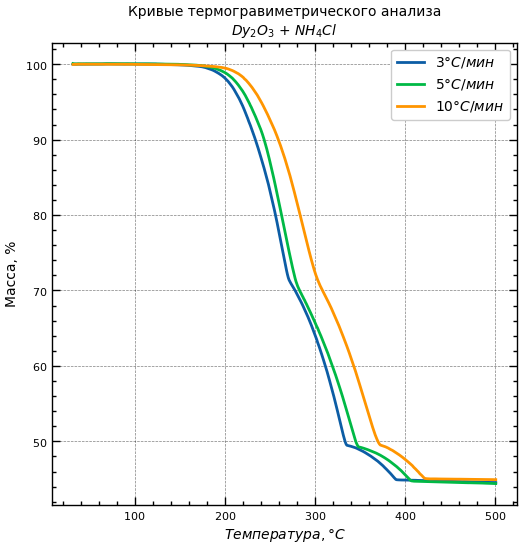

In [21]:
# Задаём константы для графиков
IS_PLOT = True
BIG_SIZE = 12
MEDIUM_SIZE = 10
SMALL_SIZE = 8 
# рабочие константы
heating_rates = np.array(['3', '5', '10']) # Скорости нагрева представленные в данных
CONSTRAINT = 0.005 # Отсечение значений ниже максимума от _ для рисунка DTG реакции
ALPHA_MIN = 0.005 # Минимальная конверсия
ALPHA_MAX = 0.995 # Максимальная конверсия
CONVERSION_BINS = 100 # Для безмодельных методов
# Рисунок какой реакции выводить на экран
TARGET_REACTION = 'reaction_0'
TARGET_RATE = 'rate_3'
# Функция аппроксимации рядом разложения p(x) для интегральных методов
def p(x):    
    numerator = x**7 + 70*x**6 + 1886*x**5 + 24920*x**4 + 170136*x**3 + 577584*x**2 + 844560*x + 357120
    denominator = x**8 + 72*x**7 + 2024*x**6 + 28560*x**5 + 216720*x**4 + 880320*x**3 + 1794240*x**2 + 1572480*x + 403200    
    result = numerator / denominator    
    return result

# Проверяем, существует ли папка, и если нет, создаем ее
if not os.path.exists(f"imgs/{ELEMENT}"):
    os.makedirs(f"imgs/{ELEMENT}")

# Создаём фигуру 
fig, axes = plt.subplots(figsize=(6, 6))

# Рисуем кривые
for rate in heating_rates:
    axes.plot(df['temperature'], df['rate_' + rate], label=f'${rate}°C/мин$')

# Добавляем подписи на оси
axes.set_xlabel('$Температура, °С$', fontsize=MEDIUM_SIZE)
axes.set_ylabel('Масса, %', fontsize=MEDIUM_SIZE)

# Добавляем заголовок
axes.set_title('Кривые термогравиметрического анализа\n' 
               + f'${ELEMENT}_2 O_3$ + $NH_4 Cl$', 
    fontsize=MEDIUM_SIZE)

# Настраиваем размер легенды и подписей осей
axes.legend(loc='upper right', fontsize=MEDIUM_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

# Сохраняем рисунок
plt.savefig(f"imgs/{ELEMENT}/{ELEMENT}_DTA.png")

plt.show()

Кинетику твердофазных реакций можно изучать с помощью термических аналитических методов путем измерения свойств образца при нагреве или при постоянной температуре. Если реакция связана с потерей массы, то масса отслеживается на протяжении реакции, и кинетика обычно изучается с помощью термогравиметрии (ТГА). Тепловой эффект (выделяющийся или поглощаемый) - это еще одно измеряемое свойство, которое используется для кинетической оценки с использованием дифференциальной сканирующей калориметрии (ДСК) или дифференциального термического анализа (ДТА). Данные о потере массы или потоке тепла преобразуются в нормализованную форму, называемую степенью превращения ($\alpha$). Степень превращения варьирует от 0 до 1 и является мерой прогресса реакции в зависимости от времени или температуры.

Для изотермического термогравиметрического анализа доля превращения в любой момент времени определяется следующим образом:

$$ \alpha = \frac{{m_0 - m_t}}{{m_0 - m_{\infty}}} \tag{1}$$

где:
$ m_0 $ - начальная масса образца,
 $ m_t $ - масса образца в момент времени $ t $, 
 $ m_{\infty} $ - конечная масса образца.


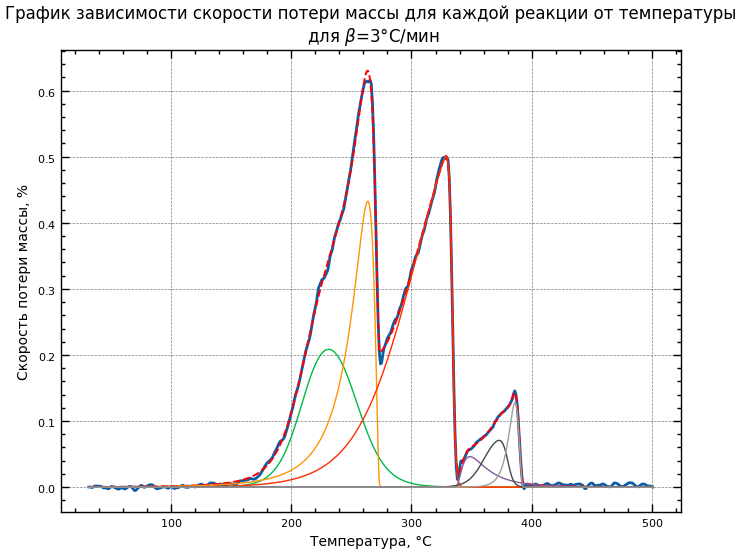

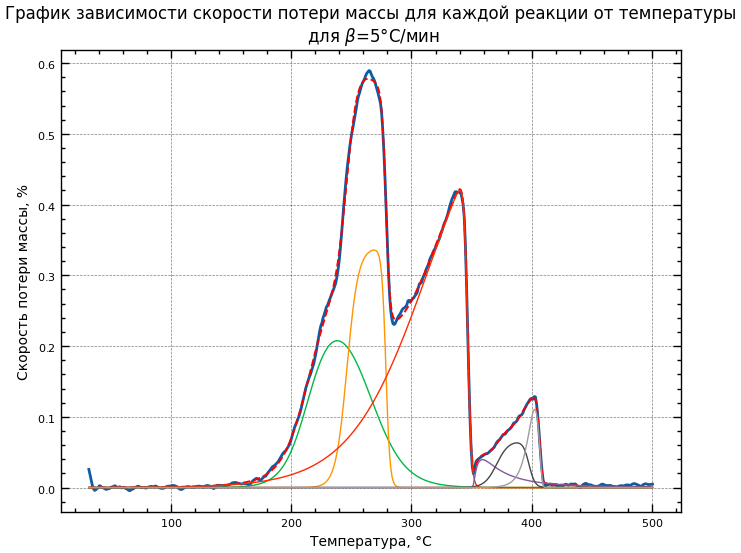

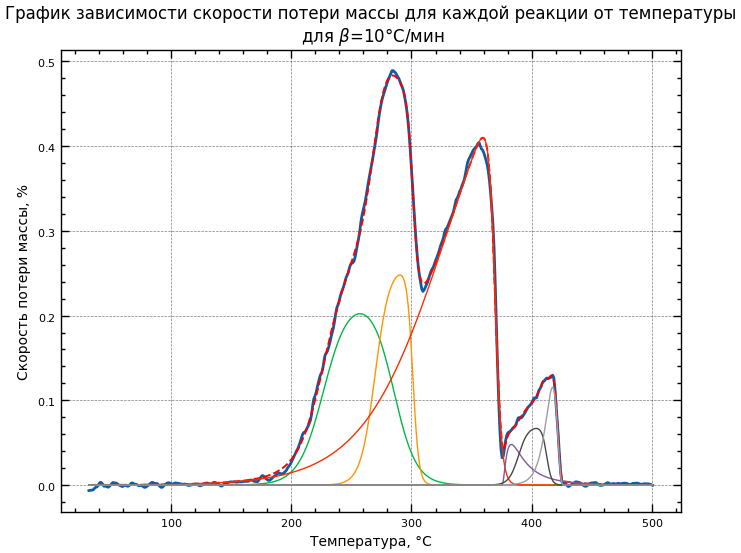

In [22]:
# Проверяем, существует ли папка, и если нет, создаем ее
if not os.path.exists(f"imgs/{ELEMENT}/DTG"):
    os.makedirs(f"imgs/{ELEMENT}/DTG")
    
for rate in heating_rates:
    # Создаём фигуру 
    fig, ax = plt.subplots(figsize=(8, 6))

    # Рисуем график для rate_X_diff с более толстой линией
    ax.plot(df['temperature'], df[f'rate_{rate}_diff'], linewidth=2, label=f'rate_{rate}_diff')

    # Рисуем график для rate_X_diff_cumulative с более тонкой линией
    ax.plot(df['temperature'], df[f'rate_{rate}_diff_cumulative'], color='r', linewidth=1.4, linestyle='--', label=f'rate_{rate}_diff_cumulative')

    # Получаем все столбцы, которые содержат "rate_X_diff_reaction"
    reaction_columns = [col for col in df.columns if f'rate_{rate}_diff_reaction' in col]

    # Рисуем графики для различных реакций при данной скорости нагрева
    for reaction in reaction_columns:
        ax.plot(df['temperature'], df[reaction], linewidth=1)

    # Добавляем подписи на оси
    ax.set_xlabel('Температура, °C', fontsize=MEDIUM_SIZE)
    ax.set_ylabel('Скорость потери массы, %', fontsize=MEDIUM_SIZE)

    # Добавляем заголовок
    ax.set_title('График зависимости скорости потери массы для каждой реакции от температуры' 
                 + f'\n для $\\beta$={rate}°C/мин', fontsize=BIG_SIZE)

    # Настраиваем размер подписей осей
    ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)
    
    # Сохраняем рисунок
    plt.savefig(f"imgs/{ELEMENT}/DTG/{rate}_DTG.png")

    plt.show()

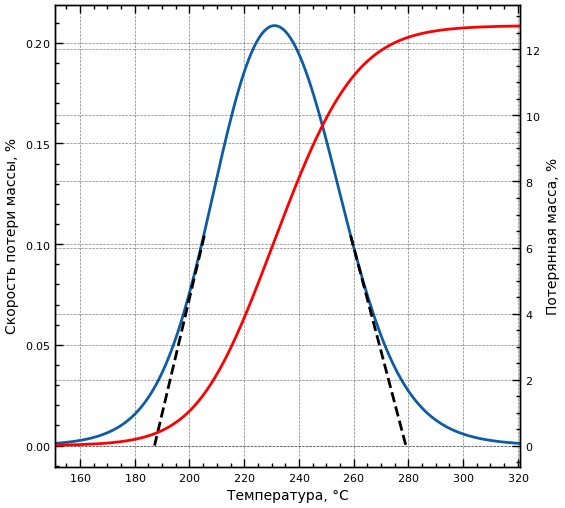

In [23]:
target_column = 'rate_3_diff_reaction_0'
# Проходим по всем rates и находим соответствующие реакции в df
for rate in heating_rates:
    # Для каждой rate создаём папку
    if not os.path.exists(f"imgs/{ELEMENT}/DTG/rate_{rate}"):
        os.makedirs(f"imgs/{ELEMENT}/DTG/rate_{rate}")

    for column in df.columns:
        if f"rate_{rate}_diff_reaction" in column:
            fig, ax = plt.subplots(figsize=(6, 6))
            ax2 = ax.twinx()

            ax.plot(df['temperature'], df[column], linewidth=2, label=column)
            ax2.plot(df['temperature'], df[column].cumsum(), 'r-', linewidth=2)
            ax2.set_ylabel('Потерянная масса, %', color='black', fontsize=MEDIUM_SIZE)
            ax2.tick_params(axis='y', labelcolor='black', labelsize=SMALL_SIZE)

            y_max = df[column].max()

            # Ограничим ось абсцисс
            relevant_temperatures = df[df[column] >= CONSTRAINT * y_max]['temperature']
            x_min = relevant_temperatures.min()
            x_max = relevant_temperatures.max()
            ax.set_xlim([x_min, x_max])

            # Код для касательных
            half_height = y_max / 2.0
            left_index = np.where(df[column] >= half_height)[0][0]
            right_index = np.where(df[column] >= half_height)[0][-1]
            left_slope = (df[column].iloc[left_index] - df[column].iloc[left_index-1]) / (df['temperature'].iloc[left_index] - df['temperature'].iloc[left_index-1])
            right_slope = (df[column].iloc[right_index] - df[column].iloc[right_index+1]) / (df['temperature'].iloc[right_index] - df['temperature'].iloc[right_index+1])
            left_intercept = df[column].iloc[left_index] - left_slope * df['temperature'].iloc[left_index]
            right_intercept = df[column].iloc[right_index] - right_slope * df['temperature'].iloc[right_index]
            left_x_intercept = -left_intercept / left_slope
            right_x_intercept = -right_intercept / right_slope

            ax.plot([df['temperature'].iloc[left_index], left_x_intercept], [half_height, 0], 'k--')
            ax.plot([df['temperature'].iloc[right_index], right_x_intercept], [half_height, 0], 'k--')

            ax.set_xlabel('Температура, °C', fontsize=MEDIUM_SIZE)
            ax.set_ylabel('Скорость потери массы, %', fontsize=MEDIUM_SIZE)
            ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

            plt.savefig(f"imgs/{ELEMENT}/DTG/rate_{rate}/{column}.png")
            
            if column == target_column:
                plt.show()
                
            plt.close()

In [24]:
# Создаём новый датафрейм conversion_df и добавляем столбец с температурой
conversion_df = pd.DataFrame()
conversion_df['temperature'] = df['temperature']

# Добавляем столбцы с кумулятивными суммами и нормализуем их
for column in df.columns:
    if "rate_" in column and "diff_reaction" in column:
        # Вычисляем конверсию как интеграл от dm/dT
        cumsum_values = df[column].cumsum()
        
        # Приводим к единице
        normalized_cumsum = cumsum_values / cumsum_values.max()
        
        # Устанавливаем конверсионные значения в новом DataFrame
        conversion_df.loc[df.index, column + '_conversion'] = normalized_cumsum

# Сохраняем conversion_df в CSV-файл
if not os.path.exists(f"data/{ELEMENT}"):
    os.makedirs(f"data/{ELEMENT}")

conversion_df.to_csv(f"data/{ELEMENT}/conversion_df.csv", index=False)

conversion_df.head()

,temperature,rate_3_diff_reaction_0_conversion,rate_3_diff_reaction_1_conversion,rate_3_diff_reaction_2_conversion,rate_3_diff_reaction_3_conversion,rate_3_diff_reaction_4_conversion,rate_5_diff_reaction_0_conversion,rate_5_diff_reaction_1_conversion,rate_5_diff_reaction_2_conversion,rate_5_diff_reaction_3_conversion,rate_5_diff_reaction_4_conversion,rate_10_diff_reaction_0_conversion,rate_10_diff_reaction_1_conversion,rate_10_diff_reaction_2_conversion,rate_10_diff_reaction_3_conversion,rate_10_diff_reaction_4_conversion,rate_3_diff_reaction_5_conversion,rate_5_diff_reaction_5_conversion,rate_10_diff_reaction_5_conversion
0,31.63192,1.348063e-09,0.000021,5.630832e-07,0.0,1.375082e-23,5.259541e-10,4.021612e-22,0.000004,0.0,7.533971e-32,1.093874e-10,1.791490e-19,0.000004,0.0,6.439128e-41,2.138283e-14,1.399716e-14,7.164865e-16
1,32.58683,2.821140e-09,0.000042,1.147740e-06,0.0,2.963244e-23,1.101792e-09,8.950424e-22,0.000008,0.0,1.666568e-31,2.293202e-10,3.892040e-19,0.000008,0.0,1.461445e-40,4.364506e-14,2.856733e-14,1.464474e-15
2,33.54175,4.430826e-09,0.000064,1.754798e-06,0.0,4.797508e-23,1.732247e-09,1.499110e-21,0.000012,0.0,2.773400e-31,3.608154e-10,6.354972e-19,0.000013,0.0,2.499414e-40,6.682466e-14,4.373510e-14,2.245405e-15
3,34.49666,6.189788e-09,0.000086,2.385115e-06,0.0,6.916005e-23,2.422497e-09,2.239443e-21,0.000016,0.0,4.114958e-31,5.049873e-10,9.242799e-19,0.000017,0.0,3.817253e-40,9.096134e-14,5.952613e-14,3.060793e-15
4,35.45158,8.111870e-09,0.000109,3.039583e-06,0.0,9.362784e-23,3.178214e-09,3.146784e-21,0.000021,0.0,5.741027e-31,6.630582e-10,1.262883e-18,0.000022,0.0,5.490428e-40,1.160966e-13,7.596726e-14,3.912223e-15


$$ Прямой~дифференциальный~метод$$
Этот метод использует скорость нагрева, обычно линейную ($\beta$), для повышения температуры. Линейная программа нагрева следует формуле:

$$ T = T_0 + \beta t \tag{2}$$

где $T_0$ - начальная температура, $\beta$ - линейная скорость нагрева (К/мин), и $T$ - температура в момент времени $t$. 

Следующее соотношение можно определить для неизотермических экспериментов:

$$ \frac{{d\alpha}}{{dT}} = \frac{{d\alpha}}{{dt}} \cdot \frac{{dt}}{{dT}} \tag{3}$$

где $\frac{{d\alpha}}{{dT}}$ - неизотермическая скорость реакции; $\frac{{d\alpha}}{{dt}}$ - изотермическая скорость реакции, а $\frac{{dt}}{{dT}}$ - скорость нагрева ($\beta$). 

Дифференциальный закон скорости для реакции первого порядка может быть записан в виде:$$ Скорость~реакции~=~\frac{d[A]}{dt}=-k[A]\tag{4}$$ 
Здесь скорость реакции (изменение концентрации $[A]$ в единицу времени) пропорциональна концентрации реагента $[A]$. Отрицательный знак указывает на то, что концентрация $[A]$ с течением времени уменьшается.


Переформулировав уравнение (4), заменим концентрацию реагента $[A]$ на степень превращения $\alpha$: $$ Скорость~реакции~=~\frac{d\alpha}{dt} = k\left(1 - \alpha\right) \tag{5}$$

Обобщим уравнение (5), введя функцию $f(\alpha)$, которая отражает специфический характер реакции.$$\frac{d\alpha}{dt} = kf(\alpha)\tag{6}$$ 

Уравнение Аррениуса, которое описывает температурную зависимость константы скорости реакции выглядит следующим образом:$$k = A e^{-\frac{E_a}{RT}} \tag{7}$$
Путем подстановки уравнения Аррениуса (7) в обобщенный дифференциальный закон скорости (6) получаем:$$\frac{d\alpha}{dt} = A e^{-\frac{E_a}{RT}}f(\alpha) \tag{8}$$
Подставляя уравнение (8) в уравнение (3), получим дифференциальную форму неизотермического закона скорости:

$$ \frac{{d\alpha}}{{dT}} = \frac{A}{\beta}  e^{-\frac{{E_a}}{{RT}}}  f(\alpha) \tag{9}$$
Откуда: $$\ln\left(\frac{{da}}{{dT}}\cdot\frac{{1}}{{f(a)}}\right) = \ln \frac{{A}}{{\beta}} - \frac{{E_a}}{{RT}} \tag{10}$$

Построение графика левой части (включая модель $f(\alpha)$) относительно $\frac{1}{T}$ позволяет получить энергию активации ($E_a$) и предэкспоненциальный множитель ($A$) из наклона и пересечения с осью $y$ соответственно. Обычно выбирается модель, которая обеспечивает наилучшую линейную аппроксимацию.


In [25]:
# Загружаем данные по кинетическим моделям
models_df = pd.read_csv('nuc_models.csv')
models_df

,Model,Differential Form,Integral Form
0,F1/3,(3/2)*(1 - a)**(1/3),1 - (1 - a)**(2/3)
1,F3/4,4*(1 - a)**(3/4),1 - (1 - a)**(1/4)
2,F3/2,2*(1 - a)**(3/2),(1 - a)**(-1/2) - 1
3,F2,(1 - a)**2,(1 - a)**(-1) - 1
4,F3,(1 - a)**3,(1 - a)**(-2) - 1
5,F1/A1,(1 - a),-np.log(1 - a)
6,A2,2*(1 - a)*(-np.log(1 - a))**(1/2),(-np.log(1 - a))**(1/2)
7,A3,3*(1 - a)*(-np.log(1 - a))**(2/3),(-np.log(1 - a))**(1/3)
8,A4,4*(1 - a)*(-np.log(1 - a))**(3/4),(-np.log(1 - a))**(1/4)
9,A2/3,(2/3)*(1 - a)*(-np.log(1 - a))**(-1/2),(-np.log(1 - a))**(3/2)


In [26]:
# ОСНОВНАЯ ФУНКЦИЯ, ИСПОЛЬЗУЮЩАЯСЯ ПО ВСЕМУ РАСЧЕТУ
def get_temperature_and_conversion(conversion_df, reaction_name):
    filtered_df = conversion_df[(conversion_df[reaction_name] > ALPHA_MIN) & (conversion_df[reaction_name] < ALPHA_MAX)]
    temperature = filtered_df['temperature'].values + 273.15 # в Кельвинах
    conversion = filtered_df[reaction_name].values
    return temperature, conversion

# Функция для вычисления значения модели в заданной точке конверсии.
# Она необходима для получения f(a), где a - степень конверсии.
def model_func(model, conversion):
    try:        
        result = eval(model, {'a': conversion, 'np': np})        
        return result
    except ZeroDivisionError:
        return np.inf

# Функция для расчета левой части уравнения при прямом дифференцировании.
# Необходима для получения выражения, которое потом будет линеаризовано.
def calculate_direct_diff_lhs(da_dT, f_a_val):
    try:
        return np.log(da_dT / f_a_val)
    except ZeroDivisionError:
        return np.inf

# Функция для отфильтровывания данных.
# Исключает значения, которые не подходят для дальнейшего анализа.
def filter_data(lhs, temperature):
    mask = np.isfinite(lhs) & np.isfinite(temperature)
    return temperature[mask], lhs[mask]

# Расчет параметров Ea и A из углового коэффициента и свободного члена линейной регрессии.
# Это окончательный шаг в анализе, дающий ключевые параметры реакции.
def calculate_direct_diff_params(slope, intercept, beta):    
    Ea = -slope * R
    A = np.exp(intercept) * int(beta)
    return Ea, A

# Функция-цель для оптимизации коэффициентов Sestak-Berggren модели.
# Цель - минимизировать (1 - R^2), чтобы улучшить качество линейной регрессии.
def objective_function(coeffs, conversion, temperature, da_dT):
    mod = f'(a**{coeffs[0]})*((1 - a)**{coeffs[1]})*(-np.log(1 - a))**({coeffs[2]})'
    f_a_val = model_func(mod, conversion)
    lhs = calculate_direct_diff_lhs(da_dT, f_a_val)
    temperature_clean, lhs_clean = filter_data(lhs, temperature)
    reverse_temperature = 1 / temperature_clean
    slope, intercept, r_value, p_value, std_err = linregress(reverse_temperature, lhs_clean)
    return 1 - r_value**2  # Минимизируем (1 - R^2)

# Функция для обработки одной модели и получения всех интересующих параметров.
# Сводит вместе все предыдущие шаги и сохраняет результаты в DataFrame.
def process_model(conversion, temperature, da_dT, model, model_name, beta):
    f_a_val = model_func(model, conversion)
    lhs = calculate_direct_diff_lhs(da_dT, f_a_val)
    temperature_clean, lhs_clean = filter_data(lhs, temperature)
    reverse_temperature = 1 / temperature_clean
    slope, intercept, r_value, p_value, std_err = linregress(reverse_temperature, lhs_clean)
    Ea, A = calculate_direct_diff_params(slope, intercept, beta)
    
    return pd.DataFrame({
        'Model': [model_name],            
        'Equation': [model],                                          
        'R2_score': [r_value**2],
        'Ea': [Ea],
        'A': [A],            
    })

# Функция для автоматического получения коэффициентов и параметров для всех моделей.
# Эта функция "оркестрирует" всем процессом, применяя все предыдущие функции к каждой модели.
def obtain_direct_diff_coeffs(conversion_df, reaction_name, models_df, beta):    
    
    direct_diff = pd.DataFrame(columns=[
        'Model', 'Equation', 'R2_score', 'Ea', 'A'])
    
    f_a = models_df['Differential Form'].to_list()
    f_names = models_df['Model'].to_list()    
    temperature, conversion = get_temperature_and_conversion(conversion_df, reaction_name)
    da_dT = np.gradient(conversion, temperature)

    for i, model in enumerate(f_a):        
        temp_df = process_model(conversion, temperature, da_dT, model, f_names[i], beta)
        direct_diff = pd.concat([direct_diff, temp_df], ignore_index=True)  

    # Блок добавления Sestak-Berrgen модели
    bounds = [(-1, 3), (-1, 3), (-3, 3)]
    de = differential_evolution(objective_function, bounds, args=(conversion, temperature, da_dT))
    coeffs = de['x']
    model = f'(a**{np.round(coeffs[0], 4)})*((1 - a)**{np.round(coeffs[1], 4)})*(-np.log(1 - a))**{np.round(coeffs[2], 4)}'
    
    temp_df = process_model(conversion, temperature, da_dT, model, "SB", beta)
    direct_diff = pd.concat([direct_diff, temp_df], ignore_index=True)
    
    return direct_diff

# Создаем папку для сохранения данных, если таковая еще не существует.
# Это необходимо, чтобы в дальнейшем сохранить результаты анализа.
direct_diff_path = f"data/{ELEMENT}/direct_diff"
if not os.path.exists(direct_diff_path):
    os.makedirs(direct_diff_path)

# Основной цикл, который проходит по всем реакциям и сохраняет результаты.
# Здесь мы применяем все предыдущие функции к каждой реакции и сохраняем результат.
for reaction_name in tqdm(conversion_df.columns):
    if reaction_name == 'temperature':
        continue
    
    # Находим скорость нагрева реакции
    beta = None
    for rate in heating_rates:
        if 'rate_'+ rate in reaction_name:
            beta = rate
            break
    if beta is None:
        raise ValueError(f"Rate not found in {reaction_name}")
    
    direct_diff = obtain_direct_diff_coeffs(conversion_df, reaction_name, models_df, beta)
    
    sorted_direct_diff = direct_diff.sort_values(by='R2_score', ascending=False)
    sorted_direct_diff.to_csv(f"data/{ELEMENT}/direct_diff/{reaction_name}.csv", index=False)


  0%|          | 0/19 [00:00<?, ?it/s]

In [27]:
if IS_PLOT:    
    def plot_for_model(dd_csv_row, colname, temperature, conversion, lhs_clean, f_a_val, reverse_temperature, beta):
        model_name = dd_csv_row['Model']
        eqn = dd_csv_row['Equation']
        Ea = dd_csv_row['Ea']
        A = dd_csv_row['A']
        R2 = dd_csv_row['R2_score']
        model_index = model_name.replace('/','_')  # Выделяем аббревиатуру модели  
        
        fig, ax = plt.subplots(figsize=(6, 6))
        
        # Первый рисунок
        slope, intercept, _, _, _ = linregress(reverse_temperature, lhs_clean)
        y = reverse_temperature * slope + intercept
        
        ax.plot(reverse_temperature, lhs_clean, 'o')
        ax.plot(reverse_temperature, y)
        ax.set_title(f'Model: {model_name}', fontsize=BIG_SIZE)
        ax.set_xlabel('1/T', fontsize=MEDIUM_SIZE)
        ax.set_ylabel(r'$\ln \left( \frac{{da}}{{dT}} \times \frac{{1}}{{f(a)}} \right)$', fontsize=BIG_SIZE)
        ax.tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)
        ax.text(0.60, 0.95, 
                r'$E_a = {:.2f}$' '\n' r'$A = {:e}$' '\n' r'$R^2 = {:.4f}$'.format(Ea, A, R2), 
                transform=ax.transAxes, 
                fontsize=BIG_SIZE, 
                verticalalignment='top', 
                bbox=dict(facecolor='white', edgecolor='black'))
        
        save_path = f"imgs/{ELEMENT}/direct_diff/{colname}/{model_index}.png"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)    
        plt.close()

    for colname in tqdm(conversion_df.columns[1:]):
        beta = None
        for rate in heating_rates:
            if f'rate_{rate}' in colname:
                beta = rate
                break
        if beta is None:
            raise ValueError(f"Rate not found in {colname}")

        dd_csv = pd.read_csv(direct_diff_path + '/' + colname + '.csv')
        temperature, conversion = get_temperature_and_conversion(conversion_df, reaction_name)
        da_dT = np.gradient(conversion, temperature)

        # Выделяем все модели, у которых R2_score больше 0.85
        selected_models = dd_csv[dd_csv['R2_score'] > 0.85]
        
        for _, row in selected_models.iterrows():
            # Загружаем уравнение лучшей функции
            f_a_val = eval(selected_models['Equation'][_], {'a': conversion, 'np': np})
            # Считаем левую часть уравнения прямого дифф метода
            lhs = calculate_direct_diff_lhs(da_dT, f_a_val)
            # Фильруем данные на случай нечисловых значений после преобразований
            temperature_clean, lhs_clean = filter_data(lhs, temperature)
            # Берем обратную температуру для построения графика
            reverse_temperature = 1 / temperature_clean
            
            plot_for_model(row, colname, temperature, conversion, lhs_clean, f_a_val, reverse_temperature, beta)

  0%|          | 0/18 [00:00<?, ?it/s]

$$Метод~Фримена~и~Кэрролла$$
Взятие натурального логарифма от дифференциальной формы закона скорости неизотермической реакции (уравнение 9) дает:

$$
\ln \frac{da}{dT} = \ln \frac{A}{\beta} - \frac{Ea}{RT} + \ln f(a) \tag{11}
$$

Если взять приращения переменных в уравнении 11, мы получим:

$$
\Delta \ln \frac{d\alpha}{dT} = \Delta \ln f(\alpha) - \frac{Ea}{R} \Delta \frac{1}{T} \tag{12}
$$

Разделив обе части уравнения на приращение обратной температуры получим:

$$
\frac{\Delta \ln \frac{d\alpha}{dT}}{\Delta \frac{1}{T}} = \frac{\Delta \ln f(\alpha)}{\Delta \frac{1}{T}} - \frac{Ea}{R} \tag{13}
$$

или

$$
\frac{\Delta \ln \frac{d\alpha}{dT}}{\Delta \ln f(\alpha)} = -\frac{Ea}{R} \frac{\Delta \frac{1}{T}}{\Delta \ln f(\alpha)} \tag{14}
$$

Активационная энергия может быть получена путем построения графика левой части уравнений (13) против $\Delta \ln f(\alpha) / \Delta \frac{1}{T}$ в точке пересечения с осью ординат. В случае уравнения (14) левая часть против $\Delta \frac{1}{T} / \Delta \ln f(\alpha)$ с нахождением угла наклона прямой.


In [28]:
# Функция для расчета левой и правой частей уравнения (13) и (14) метода Фримена и Кэрролла
def calculate_freeman_carroll_lhs_rhs(da_dT, f_a_val, temperature):
    # Заменяем нули на очень маленькие числа
    da_dT = np.maximum(da_dT, 1e-10)
    f_a_val = np.maximum(f_a_val, 1e-10)
    temperature = np.maximum(temperature, 1e-10)

    # Вычисляем градиенты
    delta_ln_da_dT = np.gradient(np.log(da_dT))
    delta_ln_f_a = np.gradient(np.log(f_a_val))
    delta_1_over_T = np.gradient(1 / temperature)
    
    # Убираем неопределенные и бесконечные значения
    mask = np.isfinite(delta_ln_da_dT) & np.isfinite(delta_ln_f_a) & np.isfinite(delta_1_over_T)
    
    delta_ln_da_dT = delta_ln_da_dT[mask]
    delta_ln_f_a = delta_ln_f_a[mask]
    delta_1_over_T = delta_1_over_T[mask]
    
    # Избегаем деления на ноль
    delta_ln_f_a_nonzero = np.where(delta_ln_f_a != 0, delta_ln_f_a, 1e-10)
    
    lhs_13 = delta_ln_da_dT / delta_1_over_T
    rhs_13 = delta_ln_f_a / delta_1_over_T

    lhs_14 = delta_ln_da_dT / delta_ln_f_a_nonzero
    rhs_14 = delta_1_over_T / delta_ln_f_a_nonzero
    
    return lhs_13, rhs_13, lhs_14, rhs_14

# Функция для обработки одной модели и получения всех интересующих параметров методом Фримена и Кэрролла
def process_model_freeman_carroll(conversion, temperature, da_dT, model, model_name, beta):
    try:
        f_a_val = model_func(model, conversion)
        lhs_13, rhs_13, lhs_14, rhs_14 = calculate_freeman_carroll_lhs_rhs(da_dT, f_a_val, temperature)

        # Линейная регрессия для уравнения (13)
        slope_13, intercept_13, r_value_13, _, _ = linregress(rhs_13, lhs_13)
        Ea_13 = -slope_13 * R

        # Линейная регрессия для уравнения (14)
        slope_14, intercept_14, r_value_14, _, _ = linregress(rhs_14, lhs_14)
        Ea_14 = -slope_14 * R

        return pd.DataFrame({
            'Model': [model_name],            
            'Equation': [model],                                          
            'R2_score_13': [r_value_13**2],
            'Ea_13': [Ea_13],
            'R2_score_14': [r_value_14**2],
            'Ea_14': [Ea_14]
        })
    except ValueError as e:
        print(f"Ошибка в модели {model_name}: {e}")
        return pd.DataFrame({
            'Model': [model_name],            
            'Equation': [model],                                          
            'R2_score_13': [0],
            'Ea_13': [0],
            'R2_score_14': [0],
            'Ea_14': [0]
        })

# Основной цикл для метода Фримена и Кэрролла
def obtain_freeman_carroll_coeffs(conversion_df, reaction_name, models_df, beta):
    freeman_carroll = pd.DataFrame(columns=[
        'Model', 'Equation', 'R2_score_13', 'Ea_13', 'R2_score_14', 'Ea_14'])
    
    f_a = models_df['Differential Form'].to_list()
    f_names = models_df['Model'].to_list()    
    temperature, conversion = get_temperature_and_conversion(conversion_df, reaction_name)
    da_dT = np.gradient(conversion, temperature)

    for i, model in enumerate(f_a):        
        temp_df = process_model_freeman_carroll(conversion, temperature, da_dT, model, f_names[i], beta)
        if temp_df is not None:
            freeman_carroll = pd.concat([freeman_carroll, temp_df], ignore_index=True)

    return freeman_carroll

freeman_carroll_path = f"data/{ELEMENT}/freeman_carroll"
if not os.path.exists(freeman_carroll_path):
    os.makedirs(freeman_carroll_path)

for reaction_name in tqdm(conversion_df.columns):
    if reaction_name == 'temperature':
        continue
    
    # Находим скорость нагрева реакции
    beta = None
    for rate in heating_rates:
        if 'rate_'+ rate in reaction_name:
            beta = rate
            break
    if beta is None:
        raise ValueError(f"Rate not found in {reaction_name}")

    freeman_carroll = obtain_freeman_carroll_coeffs(conversion_df, reaction_name, models_df, beta)
    
    sorted_freeman_carroll = freeman_carroll.sort_values(by=['R2_score_13', 'R2_score_14'], ascending=False)
    sorted_freeman_carroll.to_csv(f"data/{ELEMENT}/freeman_carroll/{reaction_name}.csv", index=False)


  0%|          | 0/19 [00:00<?, ?it/s]

Ошибка в модели F0/R1/P1: Cannot calculate a linear regression if all x values are identical
Ошибка в модели F0/R1/P1: Cannot calculate a linear regression if all x values are identical
Ошибка в модели F0/R1/P1: Cannot calculate a linear regression if all x values are identical
Ошибка в модели F0/R1/P1: Cannot calculate a linear regression if all x values are identical
Ошибка в модели F0/R1/P1: Cannot calculate a linear regression if all x values are identical
Ошибка в модели F0/R1/P1: Cannot calculate a linear regression if all x values are identical
Ошибка в модели F0/R1/P1: Cannot calculate a linear regression if all x values are identical
Ошибка в модели F0/R1/P1: Cannot calculate a linear regression if all x values are identical
Ошибка в модели F0/R1/P1: Cannot calculate a linear regression if all x values are identical
Ошибка в модели F0/R1/P1: Cannot calculate a linear regression if all x values are identical
Ошибка в модели F0/R1/P1: Cannot calculate a linear regression if all 

$$ Интегральные~методы$$

Интегрирование дифференциального неизотермического уравнения скорости приводит к интегральной форме неизотермического уравнения скорости:

$$ g(a) = \frac{A}{\beta} \int_{0}^{T} e^{\frac{-Ea}{RT}} dT \tag{15} $$

Этот интеграл называется температурным интегралом и не имеет аналитического решения. Чтобы преобразовать вышеупомянутый интеграл в более общую форму, которую можно найти в математических справочниках, переменную интегрирования можно переопределить как,

$$x = \frac{Ea}{RT}$$

и температурный интеграл становится:

$$ g(a) = \frac{AEa}{\beta R} \int_{x}^{\infty} \frac{e^{-x}}{x^2} dx \tag{16} $$

Если $p(x) = \int_{x}^{\infty} \frac{e^{-x}}{x^2} dx$, тогда уравнение 16 может быть записано как:

$$g(a) = \frac{AE_a}{\beta R} p(x) \tag{17}$$

где $p(x)$ - экспоненциальный интеграл. Основные подходы, используемые для оценки температурного/экспоненциального интеграла, включают:

1. Вычисление значений $p(x)$ численно.
2. Преобразование $p(x)$ в приближенную форму, которую можно интегрировать.
3. Аппроксимация $p(x)$ рядом разложения.


Два наиболее используемых ряда для аппроксимации температурного интеграла:

I. Асимптотическое разложение в ряд

$$p(x) = \frac{e^{-x}}{x^2} \left(1 - \frac{1}{2!x} + \frac{1}{3!x^2} - \frac{1}{4!x^3} + \ldots + (-1)^n \frac{n}{(n+1)!x^n} + \ldots \right)$$

II. Разложение в ряд Шлёмилха

$$p(x) = \frac{e^{-x}}{x(x+1)} \left(1 - \frac{1}{(x+2)} + \frac{2}{(x+2)(x+3)} - \frac{4}{(x+2)(x+3)(x+4)} + \ldots \right)$$

Многие приближения были предложены для температурного интеграла, два из которых будут рассмотрены - это приближения Дойла и Сенума-Янга. Они являются одними из наиболее распространенных приближений температурного/экспоненциального интеграла, так как каждое из них является основой для конкретного метода кинетического расчета.

$$ Приближение~Дойля $$ 

Приближение экспоненциального интеграла ($p(x)$) Дойлем основано на наблюдении, что $\log p(x)$ довольно линейно относительно $x$ в небольшом диапазоне значений $x$. Дойль приближал значения $p(x)$, используя первые три члена ряда Шлёмилха и наблюдаемое линейное соотношение для $x = 28–50$, чтобы получить по регрессии следующее приближение температурного интеграла:

$$\log p(x) = -2.315 - 0.4567x \tag{18}$$

Определено, что качество этой линейной зависимости довольно высоко с $R^2 = 0.99999$.

$$Приближение~Сенума-Янга$$ 

Сенум и Янг разработали точное нелинейное приближение температурного интеграла. Если переменные в Ур. 16 преобразуются так, что $x = zy$, то интеграл становится,

$$g(a) = \frac{AEa}{Rz} \int_{1}^{\infty} \frac{e^{zy}}{y^2} dy$$


Которое можно записать как,

$$g(a) = \frac{AEa}{Rz} E_2(z) \tag{19}$$

$E_2(z)$ или, в общем случае, $E_v(z)$ (где $v$ - целое число) - это хорошо известный интеграл для $z > 0$, заданный следующей непрерывной дробью:

$$\frac{E_v(z)}{z} = \frac{e^{-z}}{z} \cdot \cfrac{e^z}{z + \cfrac{v}{1 + \cfrac{1}{z + \cfrac{v+1}{1 + \cfrac{2}{z + \ddots}}}}} $$

Усечение числа членов в вышеприведенной непрерывной дроби дает первое (один член), второе (два члена), третье (три члена) и четвертое (четыре члена) рациональные приближения, известные как приближения Сенума-Янга.

$$ 1.~~p(x) = \frac{e^x}{x} - \frac{1}{x + 2} $$
$$ 2.~~p(x) = \frac{e^x}{x} - \frac{x + 4}{x^2 + 6x + 6} $$
$$ 3.~~p(x) = \frac{e^x}{x} - \frac{x^2 + 10x + 18}{x^3 + 12x^2 + 36x + 24} $$
$$ 4.~~p(x) = \frac{e^x}{x} - \frac{x^3 + 18x^2 + 86x + 96}{x^4 + 20x^3 + 120x^2 + 240x + 120} $$


$$ Метод~Коутса–Редферна $$

Этот метод использует интегральную форму неизотермического закона скорости (уравнение 17). Коутс и Редферн использовали асимптотическое разложение ряда для приближения температурного интеграла (p(x)), получив:

$$\ln\left(\frac{g(a)}{T^2}\right) = \ln\left(\frac{AR}{\beta E_a} \left[1 - \frac{2RT_{\text{exp}}}{E_a}\right]\right) + \frac{E_a}{RT} \tag{20}$$



где $T_{\text{exp}}$ - средняя экспериментальная температура. Построение графика левой части (включая модель, $g(a)$) уравнения 20 в отношении $1/T$ дает энергию активации ($E_a$) и частотный фактор (A) от угла наклона прямой и пересечения с осью ординат, соответственно. Выбирается модель, которая дает наилучшую линейную аппроксимацию. 

In [29]:
# Функция для вычисления левой части уравнения Coats-Redfern
def calculate_coats_redfern_lhs(g_a_val, T):
    try:
        return np.log(g_a_val / (T**2))
    except ZeroDivisionError:
        return np.inf

# Функция для расчета параметров модели Coats-Redfern
def calculate_coats_redfern_params(slope, intercept, beta, temperature):
    Ea = -slope * R
    t_mean = temperature.mean()
    A = intercept / (1 - t_mean * R * 2 / Ea) * int(beta) * Ea / R
    return Ea, A

# Функция для обработки одной модели и получения всех интересующих параметров для Coats-Redfern
def process_coats_redfern_model(conversion, temperature, model, model_name, beta, da_dT=None):
    g_a_val = model_func(model, conversion)
    lhs = calculate_coats_redfern_lhs(g_a_val, temperature)
    temperature_clean, lhs_clean = filter_data(lhs, temperature)
    reverse_temperature = 1 / temperature_clean
    slope, intercept, r_value, p_value, std_err = linregress(reverse_temperature, lhs_clean)
    Ea, A = calculate_coats_redfern_params(slope, intercept, beta, temperature)
    
    return pd.DataFrame({
        'Model': [model_name],
        'Equation': [model],
        'R2_score': [r_value**2],
        'Ea': [Ea],
        'A': [A],
    })

# Функция для автоматического получения коэффициентов и параметров для всех моделей с использованием Coats-Redfern
def obtain_coats_redfern_coeffs(conversion_df, reaction_name, models_df, beta):
    coats_redfern = pd.DataFrame(columns=['Model', 'Equation', 'R2_score', 'Ea', 'A'])
    
    g_a = models_df['Integral Form'].to_list()
    g_names = models_df['Model'].to_list()
    
    temperature, conversion = get_temperature_and_conversion(conversion_df, reaction_name)
    da_dT = np.gradient(conversion, temperature)
    
    for i, model in enumerate(g_a):
        name = g_names[i]
        try:
            temp_df = process_coats_redfern_model(conversion, temperature, model, name, beta, da_dT)
            coats_redfern = pd.concat([coats_redfern, temp_df], ignore_index=True)
        except Exception as e:
            print(f'model: {name}, eqn: {model}, Exception: {e}')
    return coats_redfern

# Создаем папку для сохранения данных для Coats-Redfern, если таковая еще не существует
coats_redfern_path = f"data/{ELEMENT}/coats_redfern"
if not os.path.exists(coats_redfern_path):
    os.makedirs(coats_redfern_path)

# Основной цикл, аналогичный direct_diff
for reaction_name in tqdm(conversion_df.columns):
    if reaction_name == 'temperature':
        continue
    
    beta = None
    for rate in heating_rates:
        if 'rate_'+ rate in reaction_name:
            beta = rate
            break
    if beta is None:
        raise ValueError(f"Rate not found in {reaction_name}")

    coats_redfern = obtain_coats_redfern_coeffs(conversion_df, reaction_name, models_df, beta)

    sorted_coats_redfern = coats_redfern.sort_values(by='R2_score', ascending=False)
    sorted_coats_redfern.to_csv(f"data/{ELEMENT}/coats_redfern/{reaction_name}.csv", index=False)


  0%|          | 0/19 [00:00<?, ?it/s]

model: E1, eqn: np.log(a), Exception: Inputs must not be empty.
model: E2, eqn: np.log(a**2), Exception: Inputs must not be empty.
model: E1, eqn: np.log(a), Exception: Inputs must not be empty.
model: E2, eqn: np.log(a**2), Exception: Inputs must not be empty.
model: E1, eqn: np.log(a), Exception: Inputs must not be empty.
model: E2, eqn: np.log(a**2), Exception: Inputs must not be empty.
model: E1, eqn: np.log(a), Exception: Inputs must not be empty.
model: E2, eqn: np.log(a**2), Exception: Inputs must not be empty.
model: E1, eqn: np.log(a), Exception: Inputs must not be empty.
model: E2, eqn: np.log(a**2), Exception: Inputs must not be empty.
model: E1, eqn: np.log(a), Exception: Inputs must not be empty.
model: E2, eqn: np.log(a**2), Exception: Inputs must not be empty.
model: E1, eqn: np.log(a), Exception: Inputs must not be empty.
model: E2, eqn: np.log(a**2), Exception: Inputs must not be empty.
model: E1, eqn: np.log(a), Exception: Inputs must not be empty.
model: E2, eqn: np.

In [30]:
if IS_PLOT:    
    def plot_for_coats_redfern(cr_csv_row, colname, temperature, conversion, lhs_clean, g_a_val, f_a_val, reverse_temperature, beta):
        model_name = cr_csv_row['Model']
        eqn = cr_csv_row['Equation']
        Ea = cr_csv_row['Ea']
        A = cr_csv_row['A']
        R2 = cr_csv_row['R2_score']
        model_index = model_name.replace('/','_') 
        
        fig, ax = plt.subplots(figsize=(6, 6))
        
        # Первый рисунок
        slope, intercept, _, _, _ = linregress(reverse_temperature, lhs_clean)
        y = reverse_temperature * slope + intercept
        
        ax.plot(reverse_temperature, lhs_clean, 'o')
        ax.plot(reverse_temperature, y)
        ax.set_title(f'Model: {model_name}', fontsize=BIG_SIZE)
        ax.set_xlabel('1/T', fontsize=MEDIUM_SIZE)
        ax.set_ylabel('Coats-Redfern LHS', fontsize=MEDIUM_SIZE)
        ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)
        ax.text(0.60, 0.95,
                    r'$E_a = {:.2f}$' '\n' r'$A = {:e}$' '\n' r'$R^2 = {:.4f}$'.format(Ea, A, R2),
                    transform=ax.transAxes,
                    fontsize=MEDIUM_SIZE,
                    verticalalignment='top',
                    bbox=dict(facecolor='white', edgecolor='black'))    
        
        save_path = f"imgs/{ELEMENT}/coats_redfern/{colname}/{model_index}.png"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        plt.close()

    # Точка входа
    for reaction_name in tqdm(conversion_df.columns):
        if reaction_name == 'temperature':
            continue
        
        beta = None
        for rate in heating_rates:
            if 'rate_' + rate in reaction_name:
                beta = rate
                break
        if beta is None:
            raise ValueError(f"Rate not found in {reaction_name}")

        cr_csv = pd.read_csv(coats_redfern_path + '/' + reaction_name + '.csv')

        sorted_coats_redfern = cr_csv.sort_values(by='R2_score', ascending=False)

        for _, row in sorted_coats_redfern.iterrows():
            if row['R2_score'] > 0.90:
                mdl = row['Model']
                equation = models_df[models_df['Model'] == mdl]['Differential Form'].item()
                
                temperature, conversion = get_temperature_and_conversion(conversion_df, reaction_name)
                
                f_a_val = eval(equation, {'a': conversion, 'np': np})
                g_a_val = eval(row['Equation'], {'a': conversion, 'np': np})
                
                lhs = calculate_coats_redfern_lhs(g_a_val, temperature)
                temperature_clean, lhs_clean = filter_data(lhs, temperature)
                reverse_temperature = 1 / temperature_clean
                
                plot_for_coats_redfern(row, reaction_name, temperature, conversion, lhs_clean, g_a_val, f_a_val, reverse_temperature, beta)


  0%|          | 0/19 [00:00<?, ?it/s]

$$ Безмодельные~методы $$
Как говорилось выше, уравнение 15 не имеет аналитического решения. По этой причине существует ряд интегральных изоконверсионных методов, которые отличаются аппроксимациями температурного интеграла $p(x)$. Многие из этих аппроксимаций приводят к линейным уравнениям общего вида:

$$\ln\left(\frac{{\alpha}_i}{T^B_i}\right) = \text{Const} - \frac{CE_a}{RT_a} \tag{21}$$

где B и C - параметры, определяемые типом аппроксимации температурного интеграла. Например, очень грубая аппроксимация Дойля, которая была выполнена для $x = 28–50$, где $x = \frac{Ea}{RT}$, дает B = 0 и C = 1.052, так что уравнение (21) принимает форму, также известную как уравнение Озавы, и/или Флинна и Уолла:

$$\ln({\alpha}_i) = \text{Const} - \frac{1.052E_a}{RT_a} \tag{22}$$

Грубая аппроксимация температурного интеграла приводит к неточным значениям $E_a$. Более точную аппроксимацию дают Мюррей и Уайт, они получают B = 2 и C = 1 и приводят к другому популярному уравнению, которое часто называют уравнением Киссинджера-Акахира-Суносе:

$$\ln\left(\frac{{\alpha}_i}{T^2_i}\right) = \text{Const} - \frac{E_a}{RT_a} \tag{23}$$

По сравнению с методом Озавы-Флинна-Уолла, метод Киссинджера-Акахира-Суносе предлагает значительное улучшение точности значений $E_a$. Как показал Старинк, несколько более точные оценки $E_a$ достигаются при установке B = 1.92 и C = 1.0008, так что уравнение (21) преобразуется в:

$$\ln\left(\frac{{\alpha}_i}{T^{1.92}_i}\right) = \text{Const} - \frac{1.0008E_a}{RT_a} \tag{24}$$

Поскольку вышеупомянутые уравнения (21) - (24) одинаково легко решить, применяя анализ линейной регрессии, рекомендуется использовать более точные уравнения, такие как (23) и (24).  Здесь следует настоятельно рекомендовать против часто встречающейся практики выполнения и отчетности по кинетическому анализу на основе одновременного использования более чем одной формы уравнения (21). Одновременное использование двух или более таких уравнений только раскрывает тривиальное различие в значениях $E_a$, вычисленных методами разной точности. Поскольку из такого сравнения не получается кинетическая информация, практику одновременного использования уравнений (21) - (24) следует исключить в пользу использования только одного более точного уравнения.


In [31]:
def get_best_fit_coeffs(x: np.ndarray, y: np.ndarray, max_degree=11) -> np.ndarray:
    best_rmse = float('inf')
    best_coeffs = None    

    for degree in range(1, max_degree + 1):
        if degree >= len(x):
            break
        coeffs = np.polyfit(x, y, degree)
        y_pred = np.polyval(coeffs, x)
        rmse = np.sqrt(((y - y_pred) ** 2).mean())
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_coeffs = coeffs        
            
    return best_coeffs

def calc_exact_temperature(reaction_name: str, conversion: float, reverse_t= False) -> np.ndarray:
    
    filtered_df = conversion_df[(conversion_df[reaction_name] > ALPHA_MIN) & (conversion_df[reaction_name] < ALPHA_MAX)]
    df = filtered_df[['temperature', reaction_name]]
        
    x, y = df[reaction_name], df['temperature'] + 273.15 # В кельвинах
    interpolated_temperature = np.interp(conversion, x, y) # Полиноминальная аппроксимация сильно переобучает
    
    if reverse_t:
        return 1 / interpolated_temperature
    
    return interpolated_temperature

def get_params(reaction: str, reverse_t=True):    
    # Собираем в массив имена столбцов с конверсиями целевой реакции при всех скоростях нагрева
    reaction_names = [col for col in conversion_df.columns if reaction in col]
    # Сортировка массива по скоростям нагрева
    reaction_names.sort(key=lambda x: int(x.split('_')[1]))
    # Задаёмся конверсией
    conversion = np.arange(ALPHA_MIN, ALPHA_MAX, 1/CONVERSION_BINS)
    # Получаем значение обратных температур для каждой реакции в точке конверсии    
    reverse_temperature = pd.DataFrame({
        reaction_name:calc_exact_temperature(reaction_name, conversion, reverse_t=reverse_t) for reaction_name in reaction_names})
    
    return reverse_temperature, conversion

def fetch_linear_approx_Ea(reaction: str) -> pd.DataFrame:    
    Ea_df = pd.DataFrame()    
    reverse_temperature, conversion = get_params(reaction)
    
    def to_seconds(rate: str) -> int:
        return int(rate) / 60 # переводим время в систему СИ
    
    OFW_lhs = [np.log(to_seconds(rate)) for rate in heating_rates] 

    def calc_KAS_lhs(row):
        KAS_lhs = []
        for i, rate in enumerate(heating_rates):
            KAS_lhs.append(np.log((to_seconds(rate)) / (row[i])**2))
        
        return KAS_lhs

    def calc_Starink_lhs(row):
        Starink_lhs = []
        for i, rate in enumerate(heating_rates):
            Starink_lhs.append(np.log((to_seconds(rate)) / (row[i])**1.92))
        
        return Starink_lhs

    Ea_df['conversion'] = conversion
    Ea_df['OFW'] = reverse_temperature.apply(lambda x: np.polyfit(x, OFW_lhs, 1)[0] * R / -1.052, axis=1)
    Ea_df['KAS'] = reverse_temperature.apply(lambda x: np.polyfit(x,  calc_KAS_lhs(x), 1)[0] * R / -1, axis=1)
    Ea_df['Starink'] = reverse_temperature.apply(lambda x: np.polyfit(x,  calc_Starink_lhs(x), 1)[0] * R / -1.008, axis=1)

    return Ea_df

# Создаем папку для сохранения данных для linear_approx, если таковая еще не существует
linear_approx_path = f"data/{ELEMENT}/linear_approx"
if not os.path.exists(linear_approx_path):
    os.makedirs(linear_approx_path)
    
# Инициализация пустого списка для хранения названий реакций
reaction_list = []

# Шаблон регулярного выражения для поиска названий реакций
pattern = re.compile(r'reaction_\d+')

# Поиск и добавление названий реакций в список
for col in conversion_df.columns:
    match = pattern.search(col)
    if match:
        reaction_name = match.group()
        if reaction_name not in reaction_list:
            reaction_list.append(reaction_name)

# Основной цикл
for reaction in reaction_list:
    linear_approx_df = fetch_linear_approx_Ea(reaction)
    linear_approx_df.to_csv(f"{linear_approx_path}/{reaction}.csv", index=False)


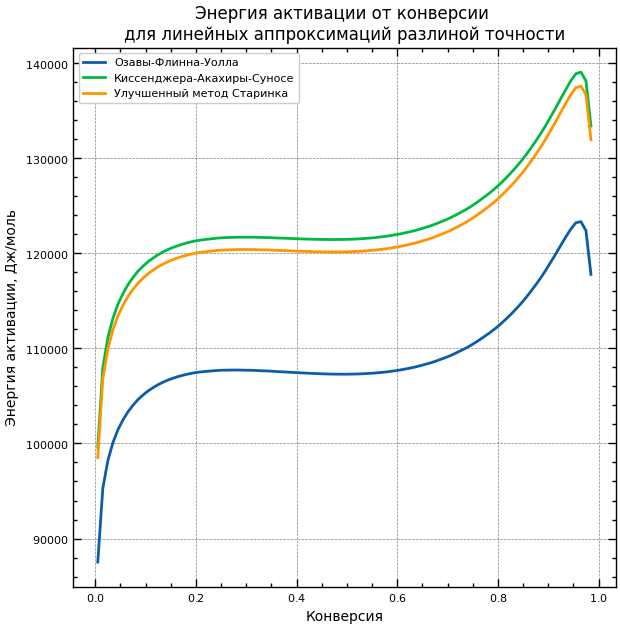

In [32]:

# Основной цикл
for reaction in reaction_list:
    fig, ax = plt.subplots(figsize=(7,7))
    Ea_df = pd.read_csv(linear_approx_path + '/' + reaction + '.csv')
    
    # отрисовываем графики для всех трех методов
    ax.plot(Ea_df['conversion'], Ea_df['OFW'], label='Озавы-Флинна-Уолла')
    ax.plot(Ea_df['conversion'], Ea_df['KAS'], label='Киссенджера-Акахиры-Суносе')
    ax.plot(Ea_df['conversion'], Ea_df['Starink'], label='Улучшенный метод Старинка')

    # устанавливаем подписи осей и название графика
    ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    ax.set_ylabel('Энергия активации, Дж/моль', fontsize=MEDIUM_SIZE)
    ax.set_title('Энергия активации от конверсии \nдля линейных аппроксимаций разлиной точности', fontsize=BIG_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

    # добавляем легенду
    ax.legend(fontsize=SMALL_SIZE)
    
    save_path = f"imgs/{ELEMENT}/linear_approx/{reaction}.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)    
    plt.savefig(save_path)
    if reaction == TARGET_REACTION:
        plt.show()
    plt.close()
    

$$ Метод~Вязовкина $$ 
Интеграл по температуре $p(x)$ в неизотермическом законе скорости (уравнение 17) является функцией Ea и температуры. Поэтому уравнение 17 можно записать следующим образом:

$$g({\alpha}) = \frac{AEa}{\beta R} I(Ea,T) \tag{25}$$

где $I(Ea, T) = p(x)$. Общее предположение, используемое в методе Вязовкина (или любом другом изоконверсионном методе), состоит в том, что модель реакции не зависит от скорости нагрева (т. е. $g_{\alpha}$ будет одинаковой при любой скорости нагрева). Поэтому для значения превращения $(\alpha)$ можно определить следующее отношение, если применяются две скорости нагрева:

$$ g({\alpha}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_1R} I(E_{a\alpha},T_{\alpha 1}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_2 R} I(E_{a\alpha},T_{\alpha 2}) \tag{26} $$

где $\beta_1$ - первая скорость нагрева, $\beta_2$ - вторая скорость нагрева, $T_{\alpha 1}$ - температура для определенного значения $\alpha$ при использовании первой скорости нагрева, $T_{\alpha 2}$ - температура при том же значении $\alpha$ при использовании второй скорости нагрева, $E_{a\alpha}$ - энергия активации при этом значении $\alpha$ и $A_{\alpha}$ - частотный фактор при этом значении $\alpha$. Для эксперимента с "n" скоростями нагрева отношение будет следующим:

$$ g({\alpha}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_1 R} I(E_{a\alpha},T_{\alpha 1}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_2 R} I(E_{a\alpha},T_{\alpha 2}) = ... = \frac{E_{a\alpha}}{\beta_n R} I(E_{a\alpha},T_{\alpha n}) \tag{27}$$ 

что сводится к:

$$ \frac{I(E_{a\alpha}, T_{\alpha 1})}{\beta_1} = \frac{I(E_{a\alpha}, T_{\alpha 2})}{\beta_2} = ... = \frac{I(E_{a\alpha}, T_{\alpha n})}{\beta_n} = \sigma \tag{28} $$

где $\sigma$ - константа.

Для двух скоростей нагрева, используя два члена в уравнении 28, мы получаем:

$$ \frac{I(E_{a\alpha},T_{\alpha 1})}{\beta_1} = \frac{I(E_{a\alpha},T_{\alpha 2})}{\beta_2} = \sigma \tag{29} $$

Если обе стороны разделить на правый или левый член, мы получаем либо:

$$ \frac{\beta_2}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 2})} = 1 \tag{30} $$ 

или

$$ \frac{\beta_1}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 1})} = 1 \tag{31} $$

Объединение уравнения 30 и уравнения 31 дает:

$$ \frac{\beta_2}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 2})} + \frac{\beta_1}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 1})} = 2 \tag{32} $$

Для трех скоростей нагрева можно получить аналогичное уравнение, как показано ниже:

$$ \frac{\beta_2}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 2})} + \frac{\beta_3}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 3})} + \frac{\beta_1}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 1})} + \frac{\beta_3}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 3})} + \frac{\beta_1}{\beta_3}\frac{I(E_{a\alpha},T_{\alpha 3})}{I(E_{a\alpha},T_{\alpha 1})} + \frac{\beta_2}{\beta_3}\frac{I(E_{a\alpha},T_{\alpha 3})}{I(E_{a\alpha},T_{\alpha 2})} = 6 \tag{33} $$

Для "n" скоростей нагрева уравнения 32 и 33 можно обобщить как:

$$ \sum_{i=1}^{n} \sum_{j \neq i} \frac{\beta_jI(E_{a\alpha},T_{\alpha i})}{\beta_iI(E_{a\alpha},T_{\alpha j})} = n(n-1) \tag{34} $$

или

$$ n(n-1) \sum_{i=1}^{n} \sum_{j \neq i} \frac{\beta_jI(E_{a\alpha},T_{\alpha i})}{\beta_iI(E_{a\alpha},T_{\alpha j})} = 0 \tag{35} $$

где температурный интеграл:

$$
I(E_\alpha, T_\alpha) = \int_0^{T_a} \exp \left(-\frac{E_\alpha}{RT}\right) dT \tag{35}
$$

Этот интеграл решается численно. Минимизация повторяется для каждого значения $\alpha$, чтобы получить зависимость $Ea$ от $\alpha$. 

Все рассмотренные до сих пор интегральные изоконверсионные уравнения (21–24, 35) основаны на решении температурного интеграла при предположении, что значение $Ea$  остается постоянным на всем интервале интеграции, то есть $Ea$  не зависит от $\alpha$. На практике $Ea$  часто изменяется с $\alpha$. Нарушение предположения о постоянстве $Ea$  вносит систематическую ошибку в значение $Ea$. Ошибка может быть значительной, до 20–30% в случае сильных изменений $Ea$  с $\alpha$. Эта ошибка не возникает в дифференциальном методе и может быть устранена в интегральных методах путем интегрирования по малым сегментам температуры или времени. Такой тип интеграции легко вводится в уравнение (35) путем вычисления температурного интеграла как:

$$
I(E_\alpha, T_\alpha) = \int_{T_a - d\alpha}^{T_a} \exp \left(-\frac{E_\alpha}{RT}\right) dT \tag{36}
$$


In [33]:
# функция под интегралом
def integrand(T, Ea):
    return np.exp(-Ea/(R*T))

# функция для вычисления температурного интеграла
def I(Ea, T, dT):
    integral, _ = integrate.quad(integrand, T - dT, T, args=(Ea,))
    return integral

def vyazovkin_lhs(Ea, dT, *args):
        
    # Вычисляем количество пар температура/скорость нагрева
    n = len(args)

    # Инициализируем переменную для накопления суммы отношений
    sum_ratio = 0
    
    # Перебираем все скорости нагрева
    for i in range(n):
        # Извлекаем температуру и скорость нагрева для текущего значения i
        T_i, beta_i = args[i]  # извлекаем кортеж (температура, скорость нагрева)        

        # Перебираем все скорости нагрева еще раз
        for j in range(n):
            # Если i не равно j (так как мы не должны сравнивать скорость нагрева с самой собой)
            if j != i:
                # Извлекаем температуру и скорость нагрева для текущего значения j
                T_j, beta_j = args[j]  # извлекаем кортеж (температура, скорость нагрева)                

                # Вычисляем отношение для текущей пары i и j и добавляем его к накопленной сумме
                I_i = I(Ea, T_i, dT)
                I_j = I(Ea, T_j, dT)
                
                sum_ratio += beta_j/beta_i * I_i/I_j

    # Вычисляем и возвращаем результат, вычитая накопленную сумму отношений из n*(n-1)
    result = n*(n-1) - sum_ratio 
    return result

def fetch_vyazovkin_df(reaction_name: str) -> pd.DataFrame:
    args_df = pd.DataFrame()
    rates = heating_rates.astype(int)
    temperature, conversion = get_params(reaction_name, reverse_t=False)
    args_df['mean_dt'] = temperature.diff().apply(lambda x: np.mean(x), axis=1)
    args_df['b_T_couples'] = temperature.apply(lambda x: list(zip(x, rates)), axis=1)
    vyazovkin_df = pd.DataFrame()

    Ea = np.arange(10000, 300001, 1000)
    for energy in Ea:    
        vyazovkin_df[energy] = args_df.apply(lambda x: vyazovkin_lhs(energy, x[0], *x[1]), axis=1)
    
    return vyazovkin_df, conversion

# Создаем папку для сохранения данных для vyazovkin, если таковая еще не существует
vyazovkin_path = f"data/{ELEMENT}/vyazovkin"
if not os.path.exists(vyazovkin_path):
    os.makedirs(vyazovkin_path)

if IS_PLOT:   
    # Основной цикл
    for reaction in reaction_list:
        vyazovkin_df, conversion = fetch_vyazovkin_df(reaction)
        vyazovkin_df.to_csv(f"{vyazovkin_path}/{reaction}.csv", index=False)


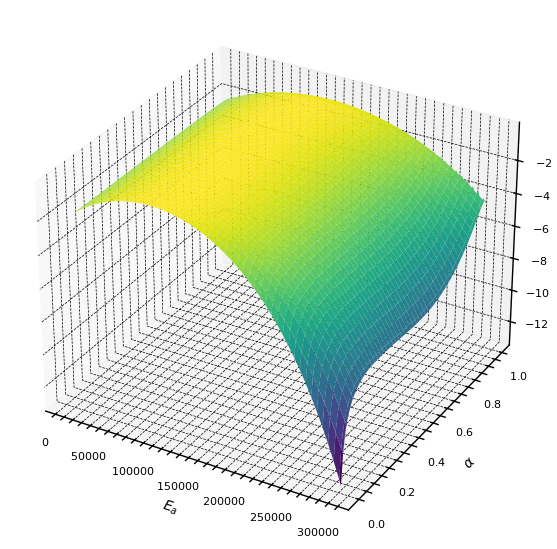

In [34]:
if IS_PLOT:
    # Основной цикл
    for reaction in reaction_list:
        vyazovkin_df = pd.read_csv(vyazovkin_path + '/' + reaction + '.csv')
        # Создаем объекты для осей x и y
        temperature, conversion = get_params(reaction, reverse_t=False)
        x = vyazovkin_df.columns.values    
        y = conversion

        # Создаем двумерный массив z значений, с использованием значений в DataFrame
        z = vyazovkin_df.values

        # Создаем сетку координат из x и y
        X, Y = np.meshgrid(x, y)

        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Отрисовываем поверхность
        surf = ax.plot_surface(X.astype(int), Y, z, cmap='viridis')

        # Устанавливаем названия осей с изменяемым размером
        ax.set_ylabel(r'$\alpha$', fontsize=MEDIUM_SIZE)
        ax.set_xlabel(r'$E_a$', fontsize=MEDIUM_SIZE)
        ax.set_zlabel(r'$\sigma$', rotation=90, fontsize=MEDIUM_SIZE)  # 

        # Изменяем размер подписей сетки осей
        ax.tick_params(axis='x', labelsize=SMALL_SIZE)
        ax.tick_params(axis='y', labelsize=SMALL_SIZE)
        ax.tick_params(axis='z', labelsize=SMALL_SIZE)

        # Поворачиваем фигуру по часовой стрелке на azim градусов
        #ax.view_init(elev=None, azim=45)

        save_path = f"imgs/{ELEMENT}/vyazovkin/{reaction}_3D.png"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)    
        plt.savefig(save_path)
        if reaction == TARGET_REACTION:
            plt.show()
        plt.close()        
            

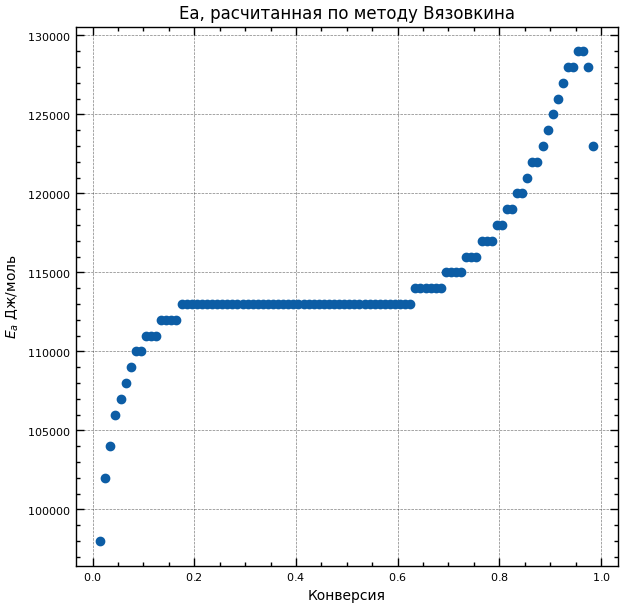

In [35]:
if IS_PLOT:
    for reaction in reaction_list:
        vyazovkin_df = pd.read_csv(vyazovkin_path + '/' + reaction + '.csv')
        y = vyazovkin_df.abs().idxmin(axis=1)[1:].astype(float)
        x = conversion[1:]
        
        fig, ax = plt.subplots(figsize=(7,7))
        
        ax.plot(x, y, 'o')
        ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
        ax.set_ylabel(r'$E_a$'+' Дж/моль', fontsize=MEDIUM_SIZE)
        ax.set_title('Ea, расчитанная по методу Вязовкина', fontsize=BIG_SIZE)
        ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)
        
        save_path = f"imgs/{ELEMENT}/vyazovkin/{reaction}_Ea.png"
        plt.savefig(save_path)
        if reaction == TARGET_REACTION:
            plt.show()
        plt.close()

## Компенсация

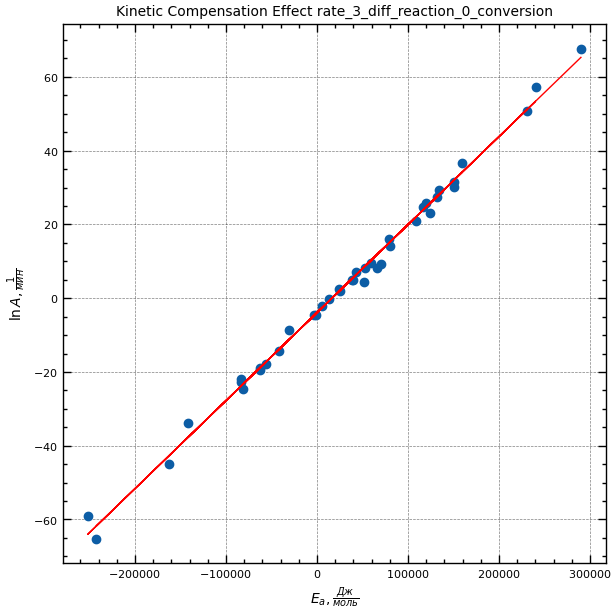

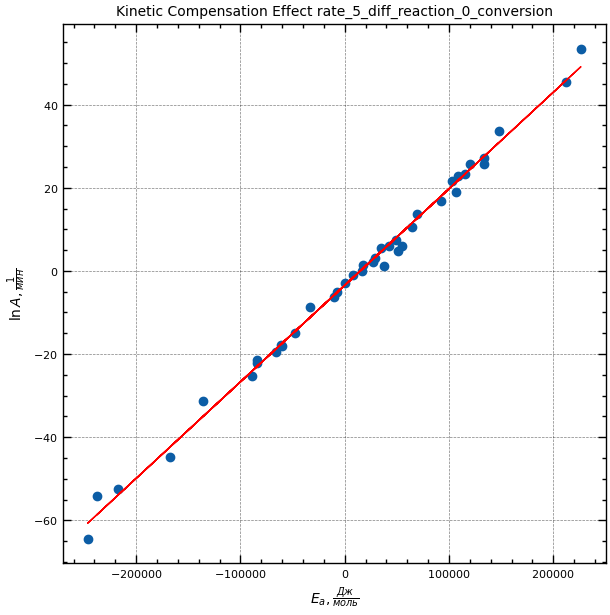

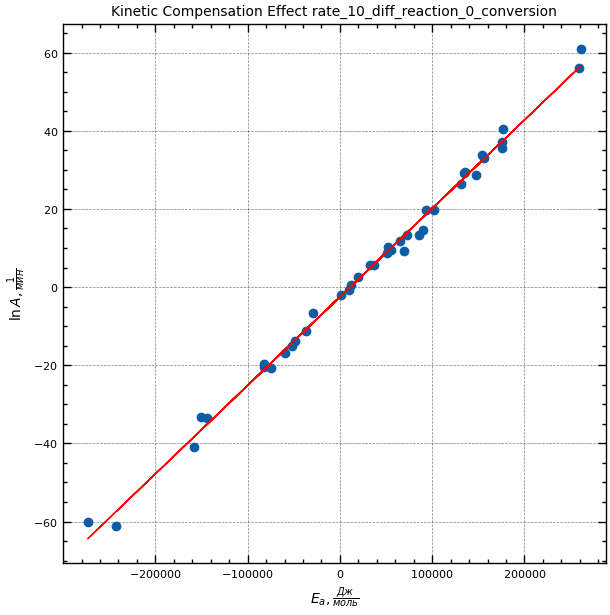

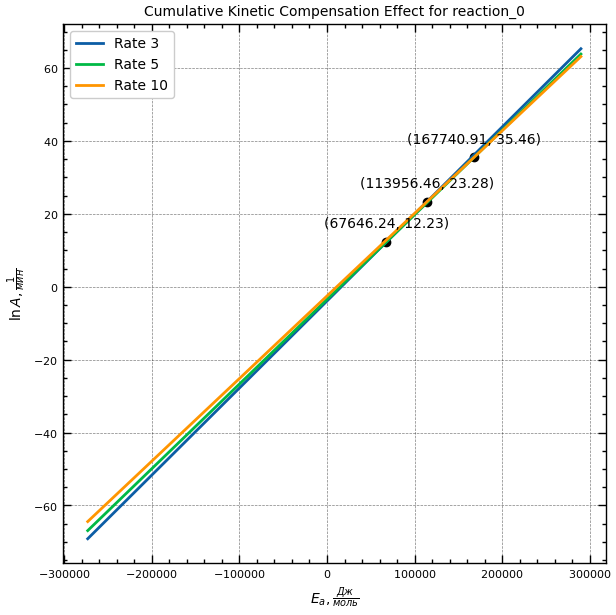

In [37]:
# Подготавливаем df на случай если реакция многостадийная
def compute_mean_A_csv(kce_csv_path, vyazovkin_path, reaction):
    kce_data_df = pd.read_csv(kce_csv_path)
    vyazovkin_df = pd.read_csv(vyazovkin_path + '/' + reaction + '.csv')

    Ea = vyazovkin_df.abs().idxmin(axis=1)[1:].astype(float)

    lnA = {}
    for rate in heating_rates:
        slope = kce_data_df[kce_data_df['rate'] == int(rate)]['slope']
        intercept = kce_data_df[kce_data_df['rate'] == int(rate)]['intercept']
        lnA[rate] = Ea.astype(float) * slope.values + intercept.values
    # Берем среднюю lnA по всем скоростям
    A = pd.DataFrame(lnA).mean(axis=1).apply(lambda x: np.exp(x))
    
    pd.DataFrame(
        {'conversion':conversion[1:],
        'A':A,
        'Ea':Ea}
    ).to_csv(kce_data_path + reaction + '_df.csv')
    
# Функция для рисования графика
def draw_single_rate_graph(ax, dd_csv, colname):
    # Оригинальные точки
    ax.plot(dd_csv['Ea'], dd_csv['log_a'], 'o')

    # Линейная регрессия
    slope, intercept, _, _, std_err = linregress(dd_csv['Ea'].values, dd_csv['log_a'].values)
    y = dd_csv['Ea'].values * slope + intercept
    ax.plot(dd_csv['Ea'].values, y, 'r-', linewidth=1)  # Красная линия шириной 1

    # Добавляем подписи на оси и заголовок
    ax.set_xlabel('$E_{a}, \\frac{Дж}{моль}$', fontsize=MEDIUM_SIZE)
    ax.set_ylabel('$\\ln A, \\frac{1}{мин}$', fontsize=MEDIUM_SIZE)
    ax.set_title(f'Kinetic Compensation Effect {colname}', fontsize=MEDIUM_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

# Функция для работы с DataFrame и сохранения графика
def process_single_rate_graph(kce_csv_path, dd_csv, colname, kce_imgs_path, rate):
    # Загрузим существующий CSV файл или создадим новый DataFrame
    if os.path.exists(kce_csv_path):
        kce_data_df = pd.read_csv(kce_csv_path)
    else:
        kce_data_df = pd.DataFrame(columns=['rate', 'slope', 'intercept', 'std_err'])
        
    fig, ax = plt.subplots(figsize=(7, 7))
    draw_single_rate_graph(ax, dd_csv, colname)

    # Сохраняем рисунок
    save_path = kce_imgs_path + f'/rate_{rate}.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    if TARGET_REACTION in colname:
        plt.show()
    plt.close() 
    
    # Добавляем данные в DataFrame
    slope, intercept, _, _, std_err = linregress(dd_csv['Ea'].values, dd_csv['log_a'].values)
    new_row = pd.DataFrame({'rate': [rate], 'slope': [slope], 'intercept': [intercept], 'std_err': [std_err]})
    kce_data_df = pd.concat([kce_data_df, new_row]).reset_index(drop=True)
    
    # Сохраняем обновленный DataFrame в CSV файл
    kce_data_df.to_csv(kce_csv_path, index=False)

# функция для нахождения точки пересечения двух прямых
def find_intersection(slope1, intercept1, slope2, intercept2):
    x_intersect = (intercept2 - intercept1) / (slope1 - slope2)
    y_intersect = slope1 * x_intersect + intercept1
    return x_intersect, y_intersect

# Точка входа 
kce_data_path = f"data/{ELEMENT}/kinetic_compensation_effect/"
os.makedirs(os.path.dirname(kce_data_path), exist_ok=True)

if IS_PLOT:
    for reaction in reaction_list:
        kce_imgs_path = f"imgs/{ELEMENT}/kinetic_compensation_effect/{reaction}"  
        kce_csv_path = f"{kce_data_path}{reaction}.csv"  
        # словарь для хранения накопленных данных
        accumulated_data = {
            'slope': [],
            'intercept': [],
            'min_Ea': float('inf'),  # инициализация максимальным значением
            'max_Ea': float('-inf')  # инициализация минимальным значением
        }

        for rate in heating_rates:
            colname = [colname for colname in conversion_df.columns if reaction in colname and 'rate_' + rate in colname]
            dd_csv = pd.read_csv(direct_diff_path + '/' + str(*colname) + '.csv')
            dd_csv['log_a'] = np.log(dd_csv['A'])
            
            # вычисление и сохранение данных для регрессии
            slope, intercept, _, _, _ = linregress(dd_csv['Ea'].values, dd_csv['log_a'].values)
            accumulated_data['slope'].append(slope)
            accumulated_data['intercept'].append(intercept)

            # обновление максимального и минимального значения
            accumulated_data['min_Ea'] = min(accumulated_data['min_Ea'], dd_csv['Ea'].values.min())
            accumulated_data['max_Ea'] = max(accumulated_data['max_Ea'], dd_csv['Ea'].values.max())

            # рисование отдельного графика
            process_single_rate_graph(kce_csv_path, dd_csv, str(*colname), kce_imgs_path, rate)        
        
        compute_mean_A_csv(kce_csv_path, vyazovkin_path, reaction)
        
        # рисование кумулятивного графика
        fig, ax = plt.subplots(figsize=(7, 7))
        x_values = np.linspace(accumulated_data['min_Ea'], accumulated_data['max_Ea'], 100)
        for idx, rate in enumerate(heating_rates):
            y_values = x_values * accumulated_data['slope'][idx] + accumulated_data['intercept'][idx]
            ax.plot(x_values, y_values, label=f'Rate {rate}')

        # поиск и отображение точек пересечения
        for i in range(len(heating_rates)):
            for j in range(i+1, len(heating_rates)):
                x_intersect, y_intersect = find_intersection(accumulated_data['slope'][i], accumulated_data['intercept'][i],
                                                            accumulated_data['slope'][j], accumulated_data['intercept'][j])
                ax.scatter(x_intersect, y_intersect, color='black')
                ax.annotate(f'({x_intersect:.2f}, {y_intersect:.2f})', (x_intersect, y_intersect),
                            textcoords="offset points", xytext=(0,10), ha='center')

        ax.set_xlabel('$E_{a}, \\frac{Дж}{моль}$', fontsize=MEDIUM_SIZE)
        ax.set_ylabel('$\\ln A, \\frac{1}{мин}$', fontsize=MEDIUM_SIZE)
        ax.set_title(f'Cumulative Kinetic Compensation Effect for {reaction}', fontsize=MEDIUM_SIZE)
        ax.legend(loc='upper left', fontsize=MEDIUM_SIZE)
        ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)
        
        save_path = kce_imgs_path + '/cumulative.png'
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        if TARGET_REACTION == reaction:
            plt.show()
        plt.close()

In [38]:

def model_func_Sestak_Berggen(conversion, coeffs):
    return coeffs[0] * conversion ** coeffs[1] * (1 - conversion) ** coeffs[2] * (-np.log(1 - conversion)) ** coeffs[3]

def model_func_Perez_Maqueda(conversion, coeffs):
    return coeffs[0] * conversion ** coeffs[1] * (1 - conversion) ** coeffs[2]

def model_func_Cai_Liu(conversion, coeffs):
    return coeffs[0] * conversion ** coeffs[1] * (1 - coeffs[2]*conversion) ** coeffs[3]

model_func_dict = {
    'Sestak-Berggen': model_func_Sestak_Berggen,
    'Perez-Maqueda': model_func_Perez_Maqueda,
    'Cai-Liu': model_func_Cai_Liu
}

bounds_dict = {
        'Sestak-Berggen': [(-20, 20), (-20, 20), (-20, 20), (-20, 20)],
        'Perez-Maqueda': [(-20, 20), (-20, 20), (-20, 20)],
        'Cai-Liu': [(-20, 20), (-20, 20), (-20, 20), (-20, 20)],        
        }

# Пример использования в objective_func
def objective_SB_func(coeffs, temperature, conversion, temp_df, model_name, beta):
    da_dT = np.gradient(conversion, temperature)
    f_a_val = model_func_dict[model_name](conversion, coeffs)        
    dadT = temp_df['A'] * f_a_val * np.exp(-temp_df['Ea']/R/temperature) / beta 
    rmse = np.sqrt(np.mean((da_dT - dadT)**2))
    return rmse

def fetch_sestak_berggen(
    sestak_berggen_path, sestak_berggen_imgs_path, reaction_name, conversion, temperature, 
    da_dT, temp_df, model_func_dict, bounds_dict, beta):
    
    # Создаем фигуру
    fig, axes = plt.subplots(figsize=(6, 6))

    # Рисуем исходные данные
    axes.plot(temperature, da_dT, label='Эксперимент')

    coeffs_df = pd.DataFrame(columns=['model_name', 'coeffs'])

    for model_name in model_func_dict.keys():
        bounds = bounds_dict[model_name]
        
        de = differential_evolution(objective_SB_func, bounds, args=(temperature, conversion, temp_df, model_name, beta))
        coeffs = de['x']
        
        # Сохраняем коэффициенты        
        new_row = pd.DataFrame({'model_name': [model_name], 'coeffs': [coeffs]})
        coeffs_df = pd.concat([coeffs_df, new_row], ignore_index=True)

        f_a_val = model_func_dict[model_name](conversion, coeffs)
        dadT = temp_df['A'] * f_a_val * np.exp(-temp_df['Ea']/R/temperature) / beta
        
        axes.plot(temperature, dadT, label=f'{model_name}')

    # Настраиваем график
    axes.set_xlabel('$Температура, °С$', fontsize=MEDIUM_SIZE)
    axes.set_ylabel('Скорость потери массы, %', fontsize=MEDIUM_SIZE)
    axes.set_title('Сравнение моделей', fontsize=MEDIUM_SIZE)
    axes.legend(loc='upper right', fontsize=SMALL_SIZE)
    axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)
    
    # Сохраняем график
    plt.savefig(f"{sestak_berggen_imgs_path}/{reaction_name}.png")
    plt.close()

    # Сохраняем DataFrame с коэффициентами
    coeffs_df.to_csv(f"{sestak_berggen_path}/{reaction_name}_coeffs.csv", index=False)


# Создаем папку для сохранения данных, если таковая еще не существует.
# Это необходимо, чтобы в дальнейшем сохранить результаты анализа.
sestak_berggen_path = f"data/{ELEMENT}/sestak_berggen/"
if not os.path.exists(sestak_berggen_path):
    os.makedirs(sestak_berggen_path)

if IS_PLOT:
    # Основной цикл, который проходит по всем реакциям и сохраняет результаты.
    # Здесь мы применяем все предыдущие функции к каждой реакции и сохраняем результат.
    for reaction_name in tqdm(conversion_df.columns):
        if reaction_name == 'temperature':
            continue
        
        # Находим скорость нагрева реакции
        beta = None
        for rate in heating_rates:
            if 'rate_'+ rate in reaction_name:
                beta = int(rate)
                break
        if beta is None:
            raise ValueError(f"Rate not found in {reaction_name}")
        
        reaction = None
        reaction = str(*[reaction for reaction in reaction_list if reaction in reaction_name])
        # Путь для сохранения рисунка
        sestak_berggen_imgs_path = f"imgs/{ELEMENT}/sestak_berggen/{reaction}"
        if not os.path.exists(sestak_berggen_imgs_path):
            os.makedirs(sestak_berggen_imgs_path)

        # Подготавливаем данные для расчета
        df_path = f"{kce_data_path}{reaction}_df.csv"
        temp_df = pd.read_csv(df_path)    
        temperature, conversion = get_params(reaction_name, reverse_t=False)
        temperature = temperature.values.flatten()[1:] # Т.к. в Ea первое значение Nan обрезано
        conversion = conversion[1:] # Т.к. в Ea первое значение Nan обрезано
        da_dT = np.gradient(conversion, temperature)
        fetch_sestak_berggen(
            sestak_berggen_path, sestak_berggen_imgs_path, reaction_name, conversion, temperature, 
            da_dT, temp_df, model_func_dict, bounds_dict, beta
        )

  0%|          | 0/19 [00:00<?, ?it/s]

## Метод Рунге-Кутты

Метод Рунге-Кутты — это метод численного решения обыкновенных дифференциальных уравнений (ОДУ). Метод четвертого порядка (RK4) — это наиболее известный и часто используемый вариант этого метода.

### Задача

Уравнение:
$$ \frac{dT}{da} = \beta  \exp\left(\frac{E_a(a)} {R  T} - ln(Af_a(a))\right)$$
Здесь $ \frac{dT}{da} $ — это производная температуры по степени превращения. Наша задача — найти температуру $ T $ как функцию степени превращения $ a $ с начальным условием $ T(a_{min}) = T_0 $.

### Метод Рунге-Кутты четвертого порядка

Метод предлагает следующий способ аппроксимации решения на каждом шаге:

1. **Первый шаг**:
$$ k_1 = h \times f(a, T) $$

2. **Второй шаг**:
$$ k_2 = h \times f\left(a + \frac{h}{2}, T + \frac{k_1}{2}\right) $$

3. **Третий шаг**:
$$ k_3 = h \times f\left(a + \frac{h}{2}, T + \frac{k_2}{2}\right) $$

4. **Четвертый шаг**:
$$ k_4 = h \times f(a + h, T + k_3) $$

5. **Обновление**:
$$ T_{next} = T + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4) $$

Применительно к нашей задаче:

- Функция $ f(a, T) $ представляет собой ваше дифференциальное уравнение, зависящее от $ a $ и $ T $.
- Значения $ E_a(a) $ и $ ln(Af_a(a)) $ определяются с помощью интерполяции из нашего набора данных `temp_df`, так как $ a $ является непрерывной переменной.

Суть метода Рунге-Кутты заключается в том, чтобы усреднить производные в начальной точке, в середине шага и в конце шага для получения более точной аппроксимации следующего значения $ T $ по сравнению с методом Эйлера, который использует только производную в начальной точке.

Метод RK4 особенно эффективен для проблем, в которых функция меняется быстро или имеет сложное поведение, так как он учитывает изменения функции на протяжении всего шага интегрирования.


  0%|          | 0/19 [00:00<?, ?it/s]

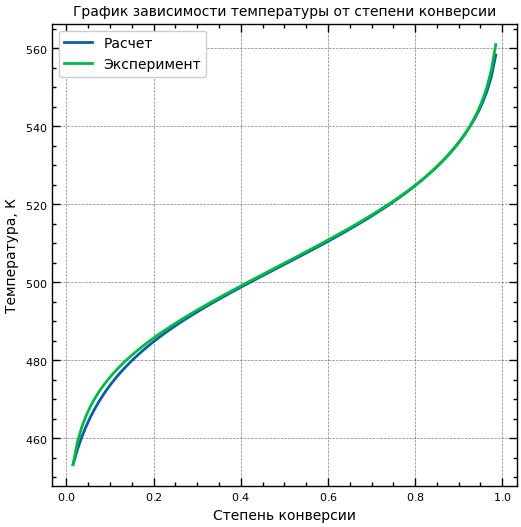

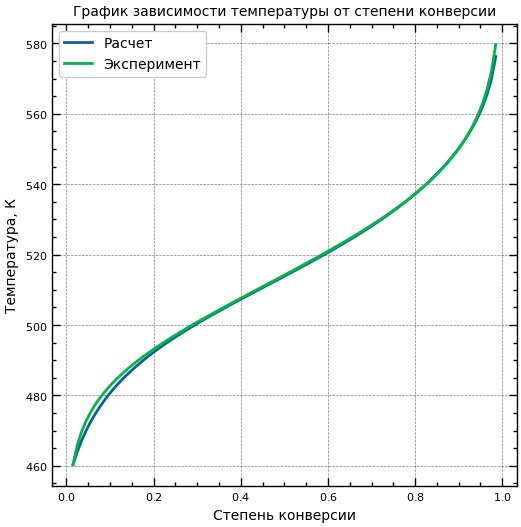

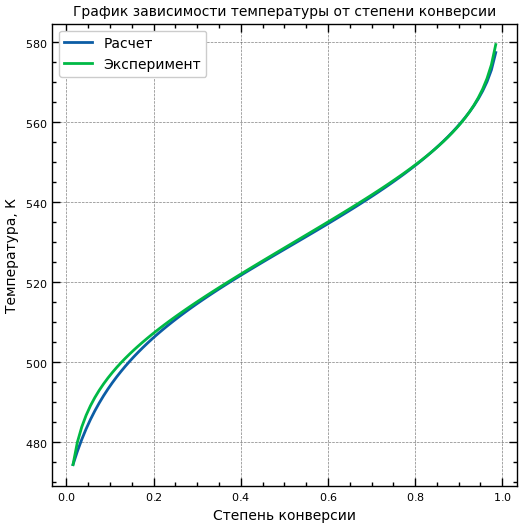

Ошибка при обработке реакции 'rate_5_diff_reaction_5_conversion': list index out of range


In [55]:
# Создаем папку для сохранения данных, если таковая еще не существует.
predictions_path = f"imgs/{ELEMENT}/predictions/"
if not os.path.exists(predictions_path):
    os.makedirs(predictions_path)

# Основной цикл, который проходит по всем реакциям и сохраняет результаты.
for reaction_name in tqdm(conversion_df.columns):
    try:
        if reaction_name == 'temperature':
            continue
        
        # Находим скорость нагрева реакции
        beta = None
        for rate in heating_rates:
            if 'rate_'+ rate in reaction_name:
                beta = float(rate)
                break
        if beta is None:
            raise ValueError(f"Rate not found in {reaction_name}")

        reaction = str(*[reaction for reaction in reaction_list if reaction in reaction_name])

        df_path = f"{kce_data_path}{reaction}_df.csv"
        model_df = pd.read_csv(f"{sestak_berggen_path}/{reaction_name}_coeffs.csv")
        temp_df = pd.read_csv(df_path)

        temperature, conversion = get_params(reaction_name, reverse_t=False)
        temperature = temperature.values.flatten()[1:] # Т.к. в Ea первое значение Nan обрезано
        conversion = conversion[1:] # Т.к. в Ea первое значение Nan обрезано

        s = model_df[model_df['model_name'] == 'Sestak-Berggen']['coeffs'].item()
        numbers = re.findall(r'-?\d+\.\d+', s)
        float_numbers = [float(num) for num in numbers]

        temp_df['ln(Afa)'] = np.log(temp_df['A'] * model_func_Sestak_Berggen(conversion, float_numbers))

        def model(a, T, beta, Ea, lnAfa, R):
            value = beta * np.exp((Ea(a)/R/T[0]) - lnAfa(a))    
            return value

        a_min = temp_df['conversion'].min()
        a_max = temp_df['conversion'].max() - 0.001
        a_values = np.linspace(a_min, a_max, len(temp_df['conversion'])) 
        T0 = temperature[0]

        Ea = interp1d(temp_df['conversion'].values, temp_df['Ea'].values, kind='linear', fill_value="extrapolate")
        lnAfa = interp1d(temp_df['conversion'].values, temp_df['ln(Afa)'].values, kind='linear', fill_value="extrapolate")

        sol = integrate.solve_ivp(model, [a_min, a_max], [T0], args=(beta, Ea, lnAfa, R), t_eval=a_values, 
                                method='RK45', max_step=2.5e-4, rtol=1e-6, atol=1e-8)

        fig, ax = plt.subplots(figsize=(6, 6))
        ax.plot(temp_df['conversion'], sol.y[0], label='Расчет')
        ax.plot(conversion, temperature, label='Эксперимент')
        ax.set_xlabel('Степень конверсии', fontsize=MEDIUM_SIZE)
        ax.set_ylabel('Температура, К', fontsize=MEDIUM_SIZE)
        ax.set_title('График зависимости температуры от степени конверсии', fontsize=MEDIUM_SIZE)
        ax.legend(loc='upper left', fontsize=MEDIUM_SIZE)
        ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

        save_path = predictions_path + reaction_name + '.png'
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        if TARGET_REACTION == reaction:
            plt.show()
        plt.close()

    except Exception as e:
        print(f"Ошибка при обработке реакции '{reaction_name}': {str(e)}")
    finally:
        plt.close()


$$ y(\alpha)~и~z(\alpha)~мастер~графики $$
После нахождения $Ea$ безмодельным методом, необходимо убедиться, что она не меняется значительно в зависимости от $\alpha$. Затем приближенно постоянное значение $Ea$ можно заменить средним значением $E_0$, которое подставляется в уравнения (37) или (39). Функция $y(\alpha)$ имеет следующую форму:

$$ y(\alpha) = \frac{d\alpha}{dt}_a \exp\left(\frac{E_0}{RT_\alpha}\right) = Af(\alpha) \tag{37} $$

Уравнение (37) легко получается путем перестановки уравнения дифференциальной формы неизотермического закона скорости реакции (9). Значения $y(\alpha)$ определяются непосредственно из экспериментальных данных путем подстановки $E_0$ в уравнение (37). Затем для каждого значения $\alpha$ необходимо определить экспериментальные значения $(d\alpha/dt)_a$ и $T_\alpha$, связанные с этим $\alpha$, и вставить их в уравнение (37). Полученные в результате экспериментальные значения $y(\alpha)$ строятся в виде функции от $\alpha$ и сравниваются с теоретическими мастер графиками $y(\alpha)$. Подходящая модель определяется как наилучшее соответствие между экспериментальными и теоретическими главными графиками $y(\alpha)$.

Как видно из уравнения (37), форма теоретических мастер графиков $y(\alpha)$ полностью определяется формой функций $f(\alpha)$, поскольку $A$ является постоянной. Однако, поскольку предэкспоненциальный фактор еще не известен, экспериментальные и теоретические графики $y(\alpha)$ должны быть нормализованы. По практическим причинам графики $y(\alpha)$ нормализуются так, чтобы они варьировались от 0 до 1. Тип модели реакции можно распознать по форме экспериментального графика $y(\alpha)$.

Мастер график $z(\alpha)$ получаются путем объединения дифференциальной и интегральной форм моделей реакции. Интеграл температуры в уравнении (15) может быть заменен на различные приближения, $\pi(x)$ следующим образом:

$$g(a) = \frac{AE}{\beta R}\exp(-x)\pi(x)/x \tag{38}$$

где $x = E/RT$. Комбинирование уравнений (9) и (38), за которым следует некоторая перестановка, позволяет ввести функцию $z(\alpha)$ в виде:

$$z(\alpha) = f(\alpha)g(\alpha) = \frac{da}{dt}_a T^2_\alpha \frac{\pi(x)}{\beta T_\alpha} \tag{39}$$

Установлено, что член дроби уравнения (39) оказывает пренебрежимое влияние на форму функции $z(\alpha)$. Таким образом, значения $z(\alpha)$ можно определить для каждого значения $\alpha$, умножив экспериментальные значения $da/dt_a$ и $T^2_a$. Полученные в результате экспериментальные значения $z(\alpha)$ строятся в виде функции от $\alpha$ и сравниваются с теоретическими мастер графиками $z(\alpha)$. Подходящая модель определяется как наилучшее соответствие между экспериментальными и теоретическими мастер графиками $z(\alpha)$. Из серии экспериментальных кинетических кривых, измеренных при различных $\beta$, можно получить серию экспериментальных графиков $z(\alpha)$, которые, однако, должны давать единственную зависимость $z(\alpha)$ от $\alpha$, практически независимую от $\beta$. Теоретические графики $z(\alpha)$ получаются путем построения произведения $f(\alpha)g(\alpha)$ против $\alpha$ для различных моделей реакции.

Следует отметить, что графики $z(\alpha)$ демонстрируют максимум при определенном значении конверсии, $a_p$, который может быть найден из условия:

$$g(\alpha)f'(\alpha) = -1 \tag{40}$$

Значения $a_p$ были рассчитаны для ряда моделей реакции. Значения могут оказать некоторую дополнительную помощь при определении подходящих моделей реакции для экспериментальных данных. Как только модель реакции была идентифицирована, предэкспоненциальный фактор определяется из следующего уравнения:

$$ A =  \frac{-\beta E_0}{R T^2_{max} f'(a_{max})}\exp\left(\frac{E_0}{RT_{max}}\right) \tag{41} $$

В уравнении (41) индекс $max$ обозначает значения, связанные с максимумом дифференциальной кинетической кривой, полученной при данной скорости нагрева.

Проблема с моделью F1/3: 'NoneType' object has no attribute 'group'
Проблема с моделью F3/4: 'NoneType' object has no attribute 'group'
Проблема с моделью F3/2: 'NoneType' object has no attribute 'group'
Проблема с моделью F2: 'NoneType' object has no attribute 'group'
Проблема с моделью F3: 'NoneType' object has no attribute 'group'
Проблема с моделью F1/A1: 'NoneType' object has no attribute 'group'
Проблема с моделью A2: 'NoneType' object has no attribute 'group'
Проблема с моделью A3: 'NoneType' object has no attribute 'group'
Проблема с моделью A4: 'NoneType' object has no attribute 'group'
Проблема с моделью A2/3: 'NoneType' object has no attribute 'group'
Проблема с моделью A3/2: 'NoneType' object has no attribute 'group'
Проблема с моделью A3/4: 'NoneType' object has no attribute 'group'
Проблема с моделью A5/2: 'NoneType' object has no attribute 'group'
Проблема с моделью F0/R1/P1: 'NoneType' object has no attribute 'group'
Проблема с моделью R2: 'NoneType' object has no attri

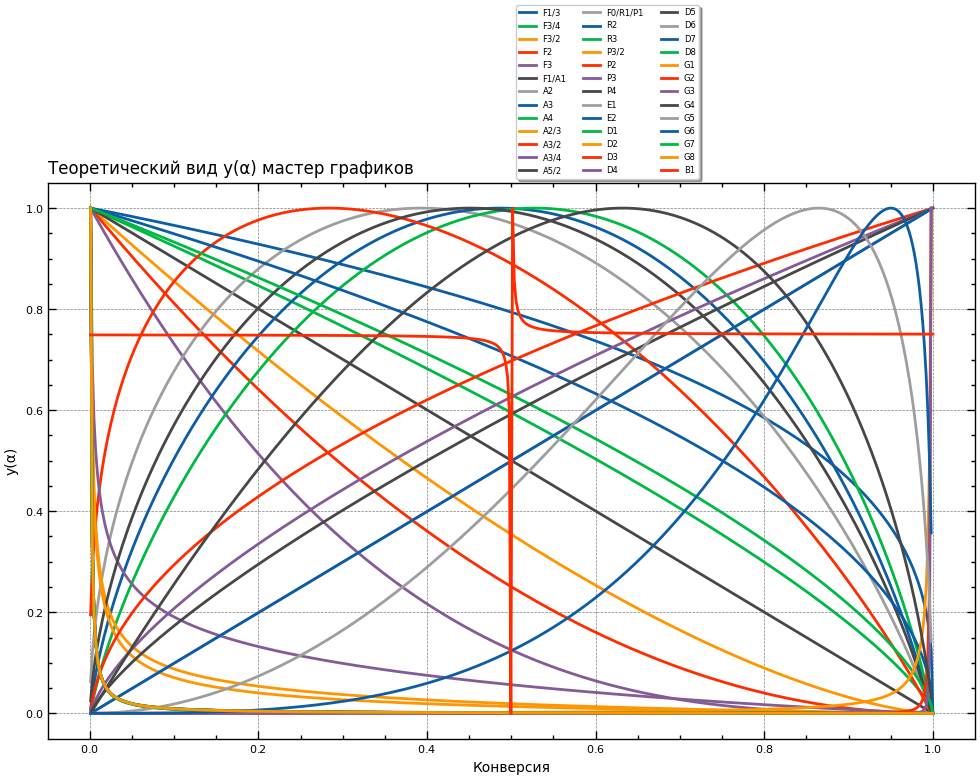

In [ ]:
# Создаем значения a от 0 до 1
a = np.linspace(0.001, 1, 500)  # Значения начинаются с 0.001, чтобы избежать деления на ноль

fig, ax = plt.subplots(figsize=(10, 8))

# DataFrame для хранения результата
ya_curves_df = pd.DataFrame()

# Цикл по всем моделям
for index, row in models_df.iterrows():
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            y = eval(row['Differential Form'])  # использование eval для интерпретации выражения как кода Python
            
            # Если максимальное значение бесконечно или np.nan, заменяем его на максимальное не-бесконечное и не-nan значение
            if np.isinf(np.max(y)) or np.isnan(np.max(y)):
                y_max = np.nanmax(y[~np.isinf(y) & ~np.isnan(y)])
            else:
                y_max = np.max(y)
                
            # Если минимальное значение бесконечно или np.nan, заменяем его на минимальное не-бесконечное и не-nan значение
            if np.isinf(np.min(y)) or np.isnan(np.min(y)):
                y_min = np.nanmin(y[~np.isinf(y) & ~np.isnan(y)])
            else:
                y_min = np.min(y)           
            
            y_norm = (y - y_min)/(y_max - y_min)  # нормализация данных
            
            ax.plot(a, y_norm, label=row['Model'])
            
            # Находим сокращенное название модели и добавляем его на график
            short_name = re.search(r'\((.*?)\)', row['Model']).group(1)
            rand_index = np.random.choice(range(len(a)))  # выбираем случайную точку для аннотации
            ax.annotate(short_name, (a[rand_index], y_norm[rand_index]), textcoords="offset points", xytext=(-10,-10), ha='center')

            # Добавляем данные в DataFrame
            temp_df = pd.DataFrame({
                'Conversion': a,
                'Normalized Differential Form': y_norm,
                'Model': row['Model']
            })
            ya_curves_df = pd.concat([ya_curves_df, temp_df])
            
    except Exception as e:
        print(f"Проблема с моделью {row['Model']}: {str(e)}")

# Настройка легенды
ax.legend(loc='best', bbox_to_anchor=(0.5, 1.00), ncol=3, fancybox=True, shadow=True, prop={'size': 6})

ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
ax.set_ylabel('y(α)', fontsize=MEDIUM_SIZE)
ax.set_title('Теоретический вид y(α) мастер графиков', fontsize=BIG_SIZE, loc='left')
ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

plt.tight_layout()
plt.show()


In [ ]:
reaction = 'reaction_0'
reaction_name = 'rate_3_diff_reaction_0_conversion'
rate = '3'
# Получаем значение температур в диапазоне конверсий 0-1 для данной реакции
temperature_a, conversion = get_params(reaction_name, conversion_bins=CONVERSION_BINS, reverse_t=False)
# Переводим температуру в градусы Цельсия
temperature_celsius = temperature_a - 273.15
# Загружаем результат расчета энергии активации методом Вязовкина (можно другой безмодельный метод)
vyazovkin_df = pd.read_csv(vyazovkin_path + '/' + reaction + '.csv')
# Вычленяем значения энергии активации от конверсии по Вязовкину(лучшая сходимость к нулю)
Ea_a = vyazovkin_df.abs().idxmin(axis=1)[1:] # 
Ea_mean = np.mean(Ea_a.astype(int).values)
# Вычисляем экспоненциальный член в уравнении для каждого значения Ea в точке конверсии
exp_term = np.exp(Ea_mean / (R * temperature_a[reaction_name][1:]))
# Фильтр для доступа к реакции
reaction_filter = (df['temperature'].values > temperature_celsius.min().item()
                   ) & (df['temperature'].values < temperature_celsius.max().item())
# Вычленяем dm/dt реакции в точке температуры
dm_dt = df[reaction_filter][['temperature', reaction_name[:-11]]]
# Создаем функцию интерполяции
f = interp1d(dm_dt['temperature'], dm_dt['rate_3_diff_reaction_0'], kind='linear', fill_value='extrapolate')
# Подставляем данные температуры в точке конверсии для получения da/dt в точке конверсии. 
# Отбрасываем первое значение так как там da/dt = NaN. Переводим da_dt в одномерный массив
da_dt = f(temperature_celsius[1:]).flatten()
# Cчитаем мастер-плот
y_a = da_dt * exp_term

y_a_norm = (y_a - y_a.min()) / (y_a.max() - y_a.min())

plt.plot(conversion[1:], y_a_norm)


TypeError: get_params() got an unexpected keyword argument 'conversion_bins'

Проблема с моделью F1/3: 'NoneType' object has no attribute 'group'
Проблема с моделью F3/4: 'NoneType' object has no attribute 'group'
Проблема с моделью F0/R1/P1: 'NoneType' object has no attribute 'group'
Проблема с моделью R2: 'NoneType' object has no attribute 'group'
Проблема с моделью R3: 'NoneType' object has no attribute 'group'
Проблема с моделью P3/2: 'NoneType' object has no attribute 'group'
Проблема с моделью P2: 'NoneType' object has no attribute 'group'
Проблема с моделью P3: 'NoneType' object has no attribute 'group'
Проблема с моделью P4: 'NoneType' object has no attribute 'group'
Проблема с моделью E1: 'NoneType' object has no attribute 'group'
Проблема с моделью E2: 'NoneType' object has no attribute 'group'
Проблема с моделью D1: 'NoneType' object has no attribute 'group'
Проблема с моделью D3: 'NoneType' object has no attribute 'group'
Проблема с моделью D4: 'NoneType' object has no attribute 'group'
Проблема с моделью D6: 'NoneType' object has no attribute 'group

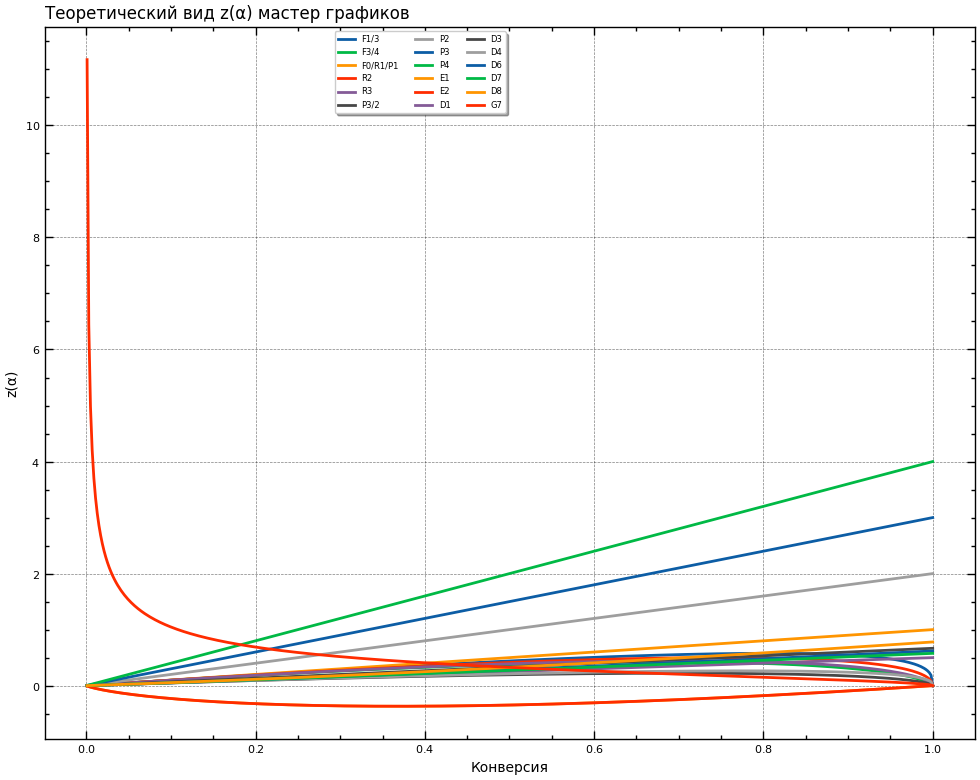

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# DataFrame для хранения результата
za_curves_df = pd.DataFrame()

for index, row in models_df.iterrows():
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            g = eval(row['Integral Form'])  # использование eval для интерпретации выражения как кода Python
            y = eval(row['Differential Form'])  # использование eval для интерпретации выражения как кода Python
            
            z = g * y  # вычисление z(a)
            
            # Проверка максимального значения в z
            if np.max(z) <= 12:
                ax.plot(a, z, label=row['Model'])
            
                # Находим сокращенное название модели и добавляем его на график
                short_name = re.search(r'\((.*?)\)', row['Model']).group(1)
                
                # Создаем маску значений x в заданном диапазоне
                mask = np.where((a >= 0.15) & (a <= 0.95))
                
                # выбираем случайную точку из заданного диапазона для аннотации
                rand_index = np.random.choice(mask[0])  
                
                ax.annotate(short_name, (a[rand_index], z[rand_index]), textcoords="offset points", xytext=(-10,-10), ha='center')

                # Добавляем данные в DataFrame
                temp_df = pd.DataFrame({
                    'Conversion': a,
                    'z(a)': z,
                    'Model': row['Model']
                })
                za_curves_df = pd.concat([za_curves_df, temp_df])
            
    except Exception as e:
        print(f"Проблема с моделью {row['Model']}: {str(e)}")

# Настройка легенды
ax.legend(loc='best', bbox_to_anchor=(0.5, 1.00), ncol=3, fancybox=True, shadow=True, prop={'size': 6})

ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
ax.set_ylabel('z(α)', fontsize=MEDIUM_SIZE)
ax.set_title('Теоретический вид z(α) мастер графиков', fontsize=BIG_SIZE, loc='left')
ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

plt.tight_layout()
plt.show()


In [ ]:
# z_data = pd.DataFrame()  # Создаем пустой DataFrame в начале

# for rate in heating_rates:
#     # Извлекаем значения конверсии для данной скорости нагрева
#     beta = int(rate)
#     query = f'conversion_{react}_{beta}'
#     conversion_rate = reactions_df[query].dropna().values[1:]
#     # Переводим индексы температуры
#     T_alpha = reactions_df[query].dropna().index[1:]
#     # Вычисляем скорость изменения конверсии
#     d_alpha_dt = np.gradient(conversion_rate) / np.gradient(T_alpha)

#     # Объединяем в один DataFrame
#     T_alpha_squared = T_alpha**2
#     conversion_rate_series = pd.Series(conversion_rate)
#     temp_data = pd.concat([pd.Series(d_alpha_dt), pd.Series(T_alpha_squared), conversion_rate_series], axis=1)
#     temp_data.columns = ['d_alpha_dt', 'T_alpha_squared', 'conversion']
#     temp_data['rate'] = rate  # добавляем столбец rate
#     z_data = pd.concat([z_data, temp_data])  # объединяем с предыдущими DataFrame
    
# z_data['z_a'] = z_data['T_alpha_squared'] * z_data['d_alpha_dt']
# z_data

In [ ]:
# fig, ax = plt.subplots(figsize=(7, 7))

# # Проходим по всем значениям скорости нагрева
# for rate in heating_rates:
#     # Получаем данные для конкретной скорости нагрева
#     x = z_data[z_data['rate'] == rate]['conversion']
#     y = z_data[z_data['rate'] == rate]['z_a']

#     # Определение размера окна для сглаживания
#     window_size = 10
    
#     # Сглаживаем данные y с помощью скользящего среднего с окном 5
#     y_smooth = y.rolling(window=window_size).mean()    

#     # Ищем максимальное значение y и соответствующее ему значение x
#     y_max = y_smooth.max()
#     x_max = np.round(x[y_smooth.idxmax()], 4)
    
#     # Строим график для x и сглаженного y
#     ax.plot(x, y_smooth, label=rate + '°C/мин, ' + f'max:{x_max}')    

# # Устанавливаем названия осей и размер шрифта
# ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
# ax.set_ylabel('z(α)', fontsize=MEDIUM_SIZE)

# # Устанавливаем размер шрифта для меток на осях
# ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

# # Показываем легенду
# ax.legend(prop={'size': 10})

# # Отображаем график
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(7, 7))

# # Проходим по всем значениям скорости нагрева
# for rate in heating_rates:
#     # Получаем данные для конкретной скорости нагрева
#     x = z_data[z_data['rate'] == rate]['conversion']
#     y = z_data[z_data['rate'] == rate]['z_a']

#     # Определение размера окна для сглаживания
#     window_size = 10

#     # Сглаживаем данные y с помощью скользящего среднего с окном 5
#     y_smooth = y.rolling(window=window_size).mean()

#     # Нормализация данных y по y при x близком к 0.5
#     closest_to_0_5 = x.iloc[(x - 0.9).abs().argsort()[:1]]
#     y_at_x_closest_0_5 = y_smooth[closest_to_0_5.index].values[0]
#     y_normalized = y_smooth / y_at_x_closest_0_5

#     # Ищем максимальное значение y и соответствующее ему значение x
#     y_max = y_normalized.max()
#     x_max = np.round(x[y_normalized.idxmax()], 4)

#     # Строим график для x и сглаженного y
#     ax.plot(x, y_normalized, label=rate + '°C/мин, ' + f'max:{x_max}')

# # Устанавливаем названия осей и размер шрифта
# ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
# ax.set_ylabel('z(α)', fontsize=MEDIUM_SIZE)

# # Устанавливаем размер шрифта для меток на осях
# ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

# # Показываем легенду
# ax.legend(prop={'size': 10})

# # Отображаем график
# plt.show()


In [ ]:


# # DataFrame для хранения результата
# max_values_df = pd.DataFrame(columns=['Model', 'Numerical Max z(a)', 'Formula Max z(a)'])

# for index, row in models_df.iterrows():
#     try:
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
            
#             g = eval(row['Integral Form'])  # использование eval для интерпретации выражения как кода Python
#             y = eval(row['Differential Form'])  # использование eval для интерпретации выражения как кода Python
#             y_diff = np.gradient(y, a)  # вычисляем численную производную от y
            
#             z = g * y  # вычисление z(a)
            
#             # Находим численный максимум функции
#             numerical_max = np.max(z)
            
#             # Находим максимум функции по формуле
#             mask = np.where(g*y_diff == -1)
#             formula_max = z[mask[0]].max() if len(mask[0]) > 0 else np.nan
            
#             # Добавляем данные в DataFrame
#             temp_df = pd.DataFrame({
#                 'Model': [row['Model']],
#                 'Numerical Max z(a)': [numerical_max],
#                 'Formula Max z(a)': [formula_max]
#             })
#             max_values_df = pd.concat([max_values_df, temp_df])
            
#     except Exception as e:
#         print(f"Проблема с моделью {row['Model']}: {str(e)}")

# # Отображаем DataFrame
# max_values_df


In [ ]:
# temperature, conversion = get_data(reactions_df, beta)

# # Создаем DataFrame, в котором будут храниться результаты
# fit_df = pd.DataFrame(columns=['Model', 'Ea', 'A', 'r_sq'])

# # Проходим по каждой строке в DataFrame с моделями
# for index, row in models_df.iterrows():
#     # Извлекаем дифференциальную форму модели
#     model = row['Differential Form']
    
#     # Определяем функцию, основанную на строке модели
#     # Эта функция принимает на вход аргумент a и строку модели, возвращает результат вычисления строки модели
#     def fa(a, model):
#         return eval(model)

#     # Проходим по каждому значению Ea в диапазоне от 5000 до 150000 с шагом 500
#     for Ea in range(5000, 340001, 500):
#         try:
#             # Вычисляем функцию, основанную на модели и преобразуем её с учетом Ea и температуры
#             func = fa(conversion[1:-1], model) * np.exp(-Ea / (R * temperature[1:-1]))
#             # Вычисляем коэффициент A как отношение последнего элемента конверсии к последнему элементу функции
#             A = conversion[1:-1][-1] / func[-1]
#             # Производим корректировку функции с помощью коэффициента A            
#             model_fit = func * A
#             cumulative_sum = np.cumsum(model_fit)  # Кумулятивная сумма
#             # Вычисляем коэффициент детерминации между реальными значениями конверсии и значениями модели
#             r_sq = r2_score(conversion[1:-1], cumulative_sum)
    
#             # Добавляем результаты в DataFrame
#             fit_df = pd.concat([fit_df, pd.DataFrame({'Model': [model], 'Ea': [Ea], 'A': [A], 'r_sq': [r_sq]})])
#         except Exception as e:
#             # Если возникает ошибка, выводим информацию о ней и прерываем текущий цикл
#             print(f"Error occurred with model: {model} and Ea: {Ea}. Error: {e}")
#             break  # Если произошла ошибка, прерываем цикл для этой модели и переходим к следующей модели

# # Сбросим индекс для fit_df
# fit_df_reset = fit_df.reset_index()

# # Находим индексы с максимальным значением r_sq для каждой модели
# idx = fit_df_reset.groupby(['Model'])['r_sq'].idxmax()

# # Создаем новый DataFrame с лучшими результатами для каждой модели
# best_fits = fit_df_reset.loc[idx]

# # Создаем два подграфика
# fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# # Проходим по каждой строке в best_fits
# for index, row in best_fits.iterrows():
#     # Вычисляем функцию для модели
#     func = fa(conversion[1:-1], row['Model']) * np.exp(-row['Ea'] / (R * temperature[1:-1])) * row['A']
#     # Если r_sq больше 0, строим модель на первой графической области
#     if row['r_sq'] > 0.8:
#         ax[0].plot(temperature[1:-1] - 273.15, func, label=f"{row['Model']}, Ea={row['Ea']}, A={np.round(row['A'],2)}, R2={np.round(row['r_sq'],4)}")
#     # Если r_sq меньше 0, строим модель на второй графической области
#     else:
#         if func.max() < 5:
#             ax[1].plot(temperature[1:-1] - 273.15, func, label=row['Model'])

# # Добавляем легенду и название для каждого графика
# ax[0].legend(loc='upper left', prop={'size': 6})
# ax[0].set_title('Модели с коэффициентом корреляции > 0', fontsize=BIG_SIZE,)
# ax[0].set_xlabel('Температура [°C]', fontsize=MEDIUM_SIZE)
# ax[0].set_ylabel('Конверсия', fontsize=MEDIUM_SIZE)
# # Устанавливаем размер шрифта для меток на осях
# ax[0].tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

# ax[1].legend(loc='upper left', prop={'size': 6})
# ax[1].set_title('Модели с коэффициентом корреляции < 0', fontsize=BIG_SIZE,)
# ax[1].set_xlabel('Температура [°C]', fontsize=MEDIUM_SIZE)
# ax[1].set_ylabel('Конверсия', fontsize=MEDIUM_SIZE)
# # Устанавливаем размер шрифта для меток на осях
# ax[1].tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

# # Выводим график конверсии в зависимости от температуры
# ax[0].plot(temperature[1:-1] - 273.15, conversion[1:-1], 'k-', label='конверсия')
# ax[1].plot(temperature[1:-1] - 273.15, conversion[1:-1], 'k-', label='конверсия')

# # Показываем график
# plt.show()

In [ ]:
# warnings.filterwarnings('ignore')

# rate = '3'
# conversion_col = f'conversion_{rate}'
# reactions_col = f'reactions_{rate}'
# mask = df[reactions_col] == 'reaction_0'
# df_masked = df[mask]

# a = df_masked[conversion_col].values
# T = (df_masked[conversion_col].index.to_series() + 273.15).values

# fig, ax = plt.subplots(figsize=(10, 6))

# def integrand(T, a, R, Ea):
#     return np.exp(-Ea/(R*T))

# def g(a, A, beta, T, Ea, R):
#     integral, error = quad(integrand, 0, T, args=(a, R, Ea))
#     return integral #A/beta *

# # Iterate over all models
# for _model_name in top_20_cr[top_20_cr['beta'] == '3']['Model'].to_list():
#     _int = models_df[models_df['Model'] == _model_name]['Integral Form']
#     g_a = eval(str(*_int.values))

#     name_mask = top_20_cr['Model'] == _model_name
#     rate_mask = top_20_cr['beta'] == rate

#     Ea = top_20_cr[(name_mask & rate_mask)]['Ea'].values
#     A = top_20_cr[(name_mask & rate_mask)]['A'].values
    
#     g_values = []
#     for a_val, T_val in zip(a, T):
#         g_val = g(a_val, A, int(rate), T_val, Ea, R)
#         g_values.append(g_val)

#     # Normalize the g values
#     min_g = min(g_values)
#     max_g = max(g_values)
#     g_values = [(g_val - min_g) / (max_g - min_g) for g_val in g_values]

#     # Draw the plot for this model with a dashed line of thickness 1
#     ax.plot(T, g_values, label=f'Model: {_model_name}', linestyle='dashed', linewidth=1)

# # Add the a versus T dependency with a line of thickness 1.5
# ax.plot(T, a, label='a(T)', linewidth=1.5, color='red')

# # Set the labels for the axes and the font size
# ax.set_xlabel('T', fontsize=MEDIUM_SIZE)
# ax.set_ylabel('Normalized g(a)', fontsize=MEDIUM_SIZE)

# # Показываем легенду
# ax.legend(prop={'size': 10})

# top_20_cr[rate_mask]


2-D diffusion (D2)	10	-(np.log(1 - a))**(-1)	-0.997890	0.995785	48514.357554	3.631679e+06

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence
import glob
import os
from tqdm import tqdm
from sklearn.metrics import r2_score


# def get_data(df, beta):
#     query = f'conversion_{react}_{beta}'
#     conversion_all = df[query].dropna().values
#     temperature_all = df[query].dropna().reset_index()['index'].values    
#     # 5% от длины данных
#     cut_index = int(len(conversion_all)*0.02)    
#     # Отбрасываем 5% данных с начала и конца
#     conversion = conversion_all[cut_index:-cut_index]  
#     temperature = temperature_all[cut_index:-cut_index]
#     return temperature, conversion


rate = '10'
t_gaus = df['10_diff'].index
s_gaus = df['10_diff'].fillna(0).values/100
t, a = get_data(df, '10')

s_gaus = s_gaus[(t_gaus >= t.min()) & (t_gaus <= t.max())]
t_gaus = t_gaus[(t_gaus >= t.min()) & (t_gaus <= t.max())]

gaus =  s_gaus * -1

t, a = get_data(df, '10')
def P2(a):
    return 2*a**(1/2)

def P3(a):
    return 3*a**(2/3)

def P4(a):
    return 4*a**(3/4)

def A2(a):
    return 2*(1 - a)*(-np.log(1 - a))**(1/2)

def A3(a):
    return 3*(1 - a)*(-np.log(1 - a))**(2/3)

def A4(a):
    return 4*(1 - a)*(-np.log(1 - a))**(3/4)

def B1(a):
    return a*(1 - a)*np.log(a/(1 - a))

def R2(a):
    return 2*(1 - a)**(1/2)

def R3(a):
    return 3*(1 - a)**(2/3)

def D1(a):
    return 1/2*a

def D2(a):
    return -(np.log(1 - a))**(-1)

def D3(a):
    return 3*(1 - a)**(2/3)/(2*(1-(1-a)**(1/3)))

def D4(a):
    return 3/2*((1 - a)**(-1/3)-1)

def F0_R1(a):
    return 1

def F1(a):
    return (1 - a)

def F2(a):
    return (1 - a)**2

def F3(a):
    return (1 - a)**3

# Создаем словарь функций
model_funcs = {
    'Power law (P2)': P2,
    'Power law (P3)': P3,
    'Power law (P4)': P4,
    'Avarami-Erofe’ev (A2)': A2,
    'Avarami-Erofe’ev (A3)': A3,
    'Avarami-Erofe’ev (A4)': A4,
    'Prout–Tompkins (B1)': B1,
    'Contracting area (R2)': R2,
    'Contracting volume (R3)': R3,
    '1-D diffusion (D1)': D1,
    '2-D diffusion (D2)': D2,
    '3-D diffusion-Jander eqn.(D3)': D3,
    'Ginstling–Brounshtein (D4)': D4,
    'Zero-order (F0/R1)': F0_R1,
    'First-order (F1)': F1,
    'Second-order (F2)': F2,
    'Third-order (F3)': F3
}


# Создаем новый DataFrame для хранения результатов
brute_force_df = pd.DataFrame(columns=['Model', 'R^2', 'Ea', 'A'])

# Проходим по каждой строке в DataFrame с моделями
for index, row in tqdm(models_df.iterrows(), total=models_df.shape[0]):
    # Извлекаем функцию модели из словаря функций
    model_func = model_funcs[row['Model']]

    # Инициализируем списки для хранения данных текущего цикла
    data = {'Model': [], 'R^2': [], 'Ea': [], 'A': []}

    # Проходим по каждому значению Ea в диапазоне от 5000 до 150000 с шагом 500
    for Ea in tqdm(range(500, 350001, 100), desc=f"Processing model {row['Model']}"):
        try:
            # Вычисляем функцию, основанную на модели и преобразуем её с учетом Ea и температуры
            func = model_func(a) / int(rate) * np.exp(-Ea / (R * t))
            # Вычисляем коэффициент A как отношение последнего элемента конверсии к последнему элементу функции
            A = np.trapz(gaus) / np.trapz(func)
            # Получаем значение подстроенной модели
            model_fit = func*A
            # Вычисляем r2_score между t,np.cumsum(x*A)/int(rate) и t_gaus, np.cumsum(gaus)/int(rate)
            r2 = r2_score(np.cumsum(model_fit), np.cumsum(gaus))

            # Добавляем значения в списки
            data['Model'].append(row['Model'])
            data['Ea'].append(Ea)
            data['A'].append(A)
            data['R^2'].append(r2)

        except Exception as e:
            # Если возникает ошибка, выводим информацию о ней и прерываем текущий цикл
            print(f"Error occurred with model: {row['Model']} and Ea: {Ea}. Error: {e}")
            break  # Если произошла ошибка, прерываем цикл для этой модели и переходим к следующей модели

    # Создаем временный DataFrame и присоединяем его к основному DataFrame
    temp_df = pd.DataFrame(data)
    brute_force_df = pd.concat([brute_force_df, temp_df], ignore_index=True)

brute_force_df

KeyError: '10_diff'

In [ ]:
idx = brute_force_df.groupby(['Model'])['R^2'].idxmax()  # получаем индексы строк с наибольшими значениями R^2 для каждой группы
best_models = brute_force_df.loc[idx]
best_models.sort_values(by='R^2', ascending=False)

,Model,R^2,Ea,A
35462,2-D diffusion (D2),0.998590,50700,8.127705e+06
24739,Contracting area (R2),0.998553,27200,1.894886e+03
28269,Contracting volume (R3),0.995871,30600,5.149096e+03
17592,Avarami-Erofe’ev (A4),0.995398,11700,7.286533e+00
14124,Avarami-Erofe’ev (A3),0.994680,14500,2.606982e+01
10684,Avarami-Erofe’ev (A2),0.993158,20100,2.813682e+02
39067,3-D diffusion-Jander eqn.(D3),0.989958,61600,1.593975e+08
49310,First-order (F1),0.988129,37100,2.245859e+05
45607,Zero-order (F0/R1),0.986652,16400,4.172638e+01
33,Power law (P2),0.986319,3800,3.178445e-01


In [ ]:
models_df

,Model,Differential Form,Integral Form
0,Power law (P2),2*a**(1/2),a**(1/2)
1,Power law (P3),3*a**(2/3),a**(1/3)
2,Power law (P4),4*a**(3/4),a**(1/4)
3,Avarami-Erofe’ev (A2),2*(1 - a)*(-np.log(1 - a))**(1/2),(-np.log(1 - a))**(1/2)
4,Avarami-Erofe’ev (A3),3*(1 - a)*(-np.log(1 - a))**(2/3),(-np.log(1 - a))**(1/3)
5,Avarami-Erofe’ev (A4),4*(1 - a)*(-np.log(1 - a))**(3/4),(-np.log(1 - a))**(1/4)
6,Prout–Tompkins (B1),a*(1 - a)*np.log(a/(1 - a)),np.log(a/(1 - a))
7,Contracting area (R2),2*(1 - a)**(1/2),1-(1 - a)**(1/2)
8,Contracting volume (R3),3*(1 - a)**(2/3),1-(1 - a)**(1/3)
9,1-D diffusion (D1),1/2*a,a**2
